# Building Machine Learning Systems with Python - Chapter 1

This code is supporting material for the book `Building Machine Learning Systems with Python` by [Willi Richert](https://www.linkedin.com/in/willirichert/) and [Luis Pedro Coelho](https://www.linkedin.com/in/luispedrocoelho/)  published by PACKT Publishing.

It is made available under the MIT License.

All code examples use Python in version...

In [1]:
import sys
sys.version

'3.10.8 (main, Nov 16 2022, 17:55:27) [GCC 9.4.0]'

## NumPy and SciPy

In [2]:
import numpy as np
np.version.full_version

'1.25.0'

In [3]:
a = np.array([0,1,2,3,4,5])
a

array([0, 1, 2, 3, 4, 5])

In [4]:
a.ndim

1

In [5]:
a.shape

(6,)

In [6]:
b = a.reshape((3,2))
b

array([[0, 1],
       [2, 3],
       [4, 5]])

In [7]:
b.ndim

2

In [8]:
b.shape

(3, 2)

Most often you are working on views to speed up your code, ...

In [9]:
b[1][0] = 77
b

array([[ 0,  1],
       [77,  3],
       [ 4,  5]])

... which means that `a[2]` is also changed:

In [10]:
a

array([ 0,  1, 77,  3,  4,  5])

If you want a copy, `copy`:

In [11]:
c = a.reshape((3,2)).copy()
c

array([[ 0,  1],
       [77,  3],
       [ 4,  5]])

In [12]:
c[0][0] = -99
c

array([[-99,   1],
       [ 77,   3],
       [  4,   5]])

In [13]:
a

array([ 0,  1, 77,  3,  4,  5])

Ahhh, `a[0]` is not changed.

### Broadcasting

In [14]:
d = np.array([1,2,3,4,5])
d*2

array([ 2,  4,  6,  8, 10])

In [15]:
d**2

array([ 1,  4,  9, 16, 25], dtype=int32)

Works differently for normal Python lists:

In [16]:
[1,2,3,4,5]*2

[1, 2, 3, 4, 5, 1, 2, 3, 4, 5]

In [17]:
try:
    [1,2,3,4,5]**2 # does not work on normal lists
except TypeError as e:
    print("Exception: %s"%e)

Exception: unsupported operand type(s) for ** or pow(): 'list' and 'int'


### Indexing
One can use a list as an index itself, which will then pick the elements individually from that dimension:

In [18]:
a[np.array([2,3,4])]

array([77,  3,  4])

In [19]:
a[[2,3,4]] # normal lists work, too

array([77,  3,  4])

In [20]:
a>4

array([False, False,  True, False, False,  True])

In [21]:
a[a>4] = 4
a

array([0, 1, 4, 3, 4, 4])

In [22]:
a.clip(0,4)

array([0, 1, 4, 3, 4, 4])

### Handling non-existing values (NaN, etc.)

In [23]:
c = np.array([1, 2, np.NAN, 3, 4]) # let's pretend we have read this from a text file
c

array([ 1.,  2., nan,  3.,  4.])

In [24]:
np.isnan(c)

array([False, False,  True, False, False])

We can use it to select only those fields that are not NaN:

In [25]:
c[~np.isnan(c)]

array([1., 2., 3., 4.])

In [26]:
np.mean(c[~np.isnan(c)])

2.5

## Speed

In [27]:
import timeit
normal_py_sec = timeit.timeit('sum(x*x for x in range(1000))',
                              number=10000)
naive_np_sec = timeit.timeit(
                'sum(na*na)',
                setup="import numpy as np; na=np.arange(1000)",
                number=10000)
good_np_sec = timeit.timeit(
                'na.dot(na)',
                setup="import numpy as np; na=np.arange(1000)",
                number=10000)

print("Normal Python: %f sec" % normal_py_sec)
print("Naive NumPy: %f sec" % naive_np_sec)
print("Good NumPy: %f sec" % good_np_sec)

Normal Python: 1.124191 sec
Naive NumPy: 0.766488 sec
Good NumPy: 0.013278 sec


In [28]:
print("Speed-up: %f" % (normal_py_sec / good_np_sec))

Speed-up: 84.665156


In [29]:
1.621358/0.035686

45.43400773412542

But: less flexibility:

In [30]:
a = np.array([1,2,3])
a.dtype

dtype('int32')

In [31]:
np.array([1, "stringy"])

array(['1', 'stringy'], dtype='<U11')

In [32]:
np.array([1, "stringy", {1, 2, 3}])

array([1, 'stringy', {1, 2, 3}], dtype=object)

## Our first tiny application

In [5]:
import scipy
scipy.version.full_version

'1.11.1'

## Generating some toy data for our web startup

In [6]:
# This script generates web traffic data for our hypothetical
# web startup "MLaaS"

import os
from scipy.stats import gamma
import matplotlib.pyplot as plt
%matplotlib inline

DATA_DIR = os.path.join(os.getcwd(), "data")
CHART_DIR = os.path.join(os.getcwd(), "charts")

for d in [DATA_DIR, CHART_DIR]:
    if not os.path.exists(d):
        os.mkdir(d)

np.random.seed(3)  # to reproduce the data later on

def gen_web_traffic_data():
    '''
    This function generates some fake data that first shows a weekly pattern 
    for a couple weeks before it grows exponentially.
    '''
    x = np.arange(1, 31*24)
    y = np.array(200*(np.sin(2*np.pi*x/(7*24))), dtype=np.float32)
    y += gamma.rvs(15, loc=0, scale=100, size=len(x))
    y += 2 * np.exp(x/100.0)
    y = np.ma.array(y, mask=[y<0])

    # We introduce some "real-world" data, to later demonstrate how to clean 
    # it conveniently.
    y[[2,23,48,95,154,180,181,210]] = np.nan

    return x, y

def plot_web_traffic(x, y, models=None, mx=None, ymax=None, fig_idx=None):
    '''
    Plot the web traffic (y) over time (x). 
    
    If models is given, it is expected to be a list fitted models,
    which will be plotted as well (used later in this chapter).
    '''
    plt.figure(figsize=(12,6), dpi=300) # width and height of the plot in inches
    plt.scatter(x, y, s=10)
    plt.title("Web traffic over the last month")
    plt.xlabel("Time")
    plt.ylabel("Hits/hour")
    plt.xticks([w*7*24 for w in range(20)], 
               ['week %i' %w for w in range(20)])
    
    if models:
        colors = ['g', 'k', 'b', 'm', 'r']
        linestyles = ['-', '-.', '--', ':', '-']

        if mx is None:
            mx = np.linspace(0, x[-1], 1000)
        for model, style, color in zip(models, linestyles, colors):
            plt.plot(mx, model(mx), linestyle=style, linewidth=2, c=color)

        plt.legend(["d=%i" % m.order for m in models], loc="upper left")
        
    plt.autoscale()
    if ymax:
        plt.ylim(ymax=ymax)

    plt.grid()
    plt.ylim(ymin=0)
    
    if fig_idx is not None:
        plt.savefig(os.path.join(CHART_DIR, "B09124_01_%s.png" % fig_idx))

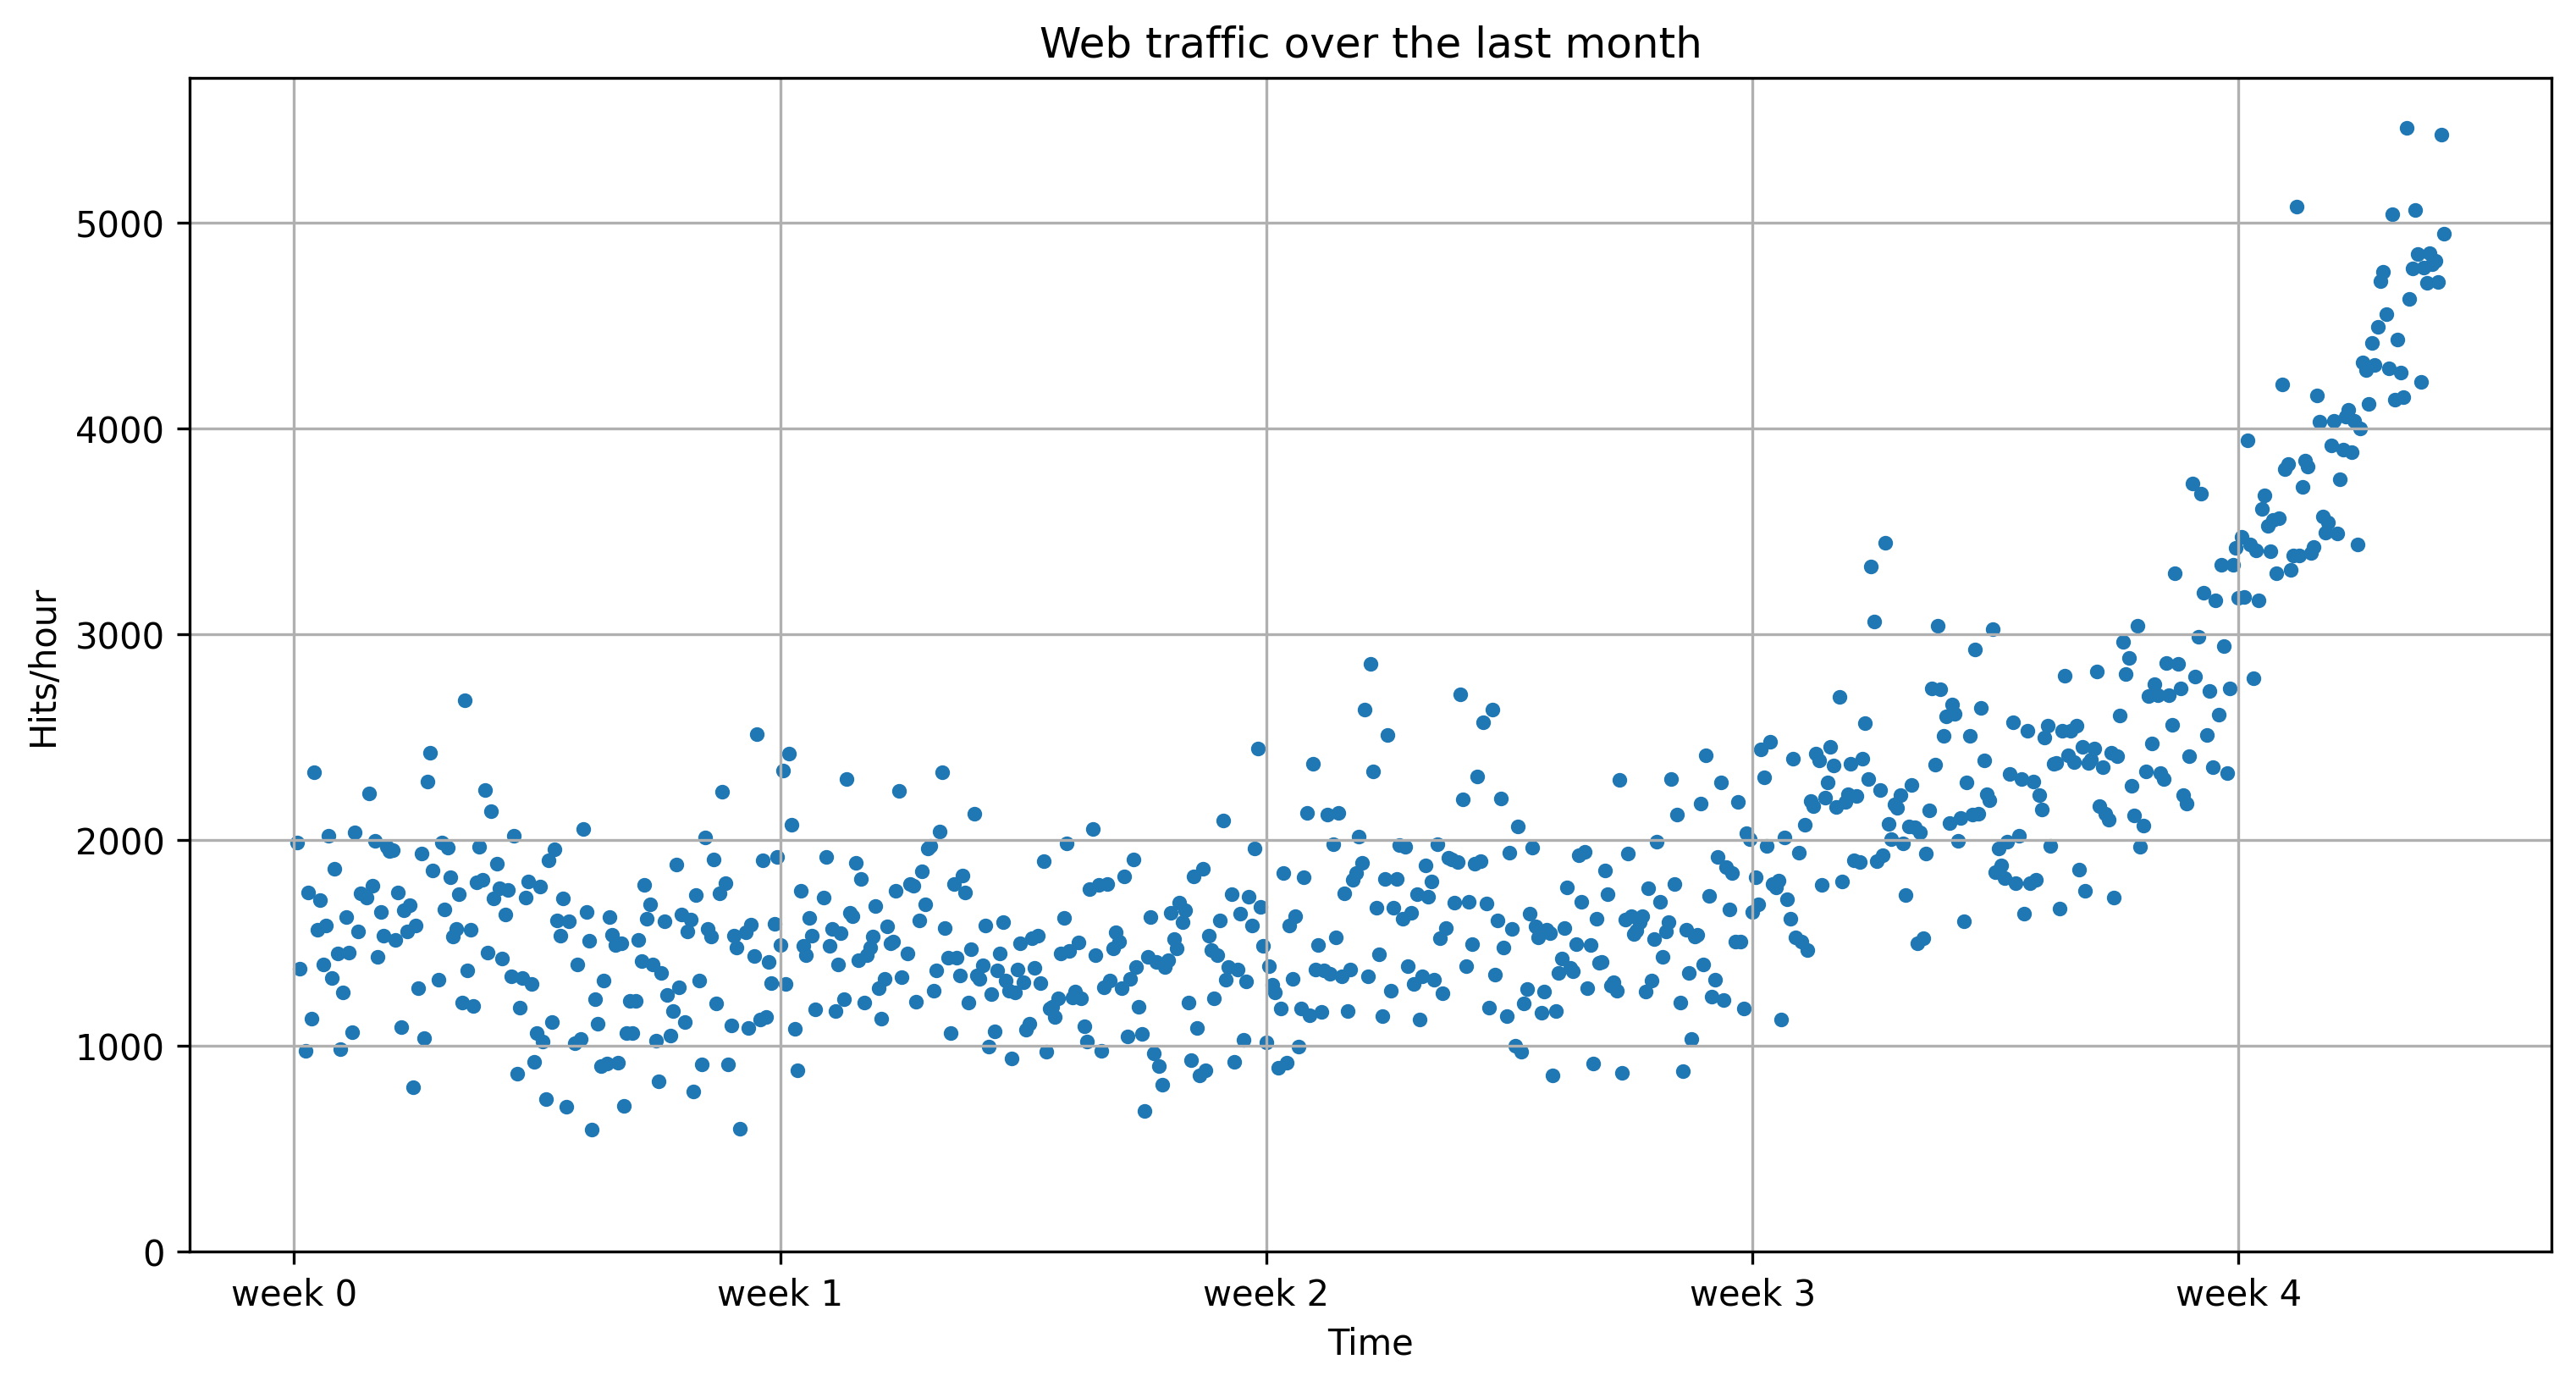

In [8]:
x, y = gen_web_traffic_data()
np.savetxt(os.path.join(DATA_DIR, "web_traffic.tsv"), 
           list(zip(x, y)), delimiter="\t", fmt="%f")
    
plot_web_traffic(x, y, fig_idx="01")

## Reading in the data and cleaning it

In [9]:
data = np.genfromtxt(os.path.join(DATA_DIR, "web_traffic.tsv"), delimiter="\t")

In [10]:
print(data[:10])

[[1.00000000e+00 1.98614062e+03]
 [2.00000000e+00 1.37566565e+03]
 [3.00000000e+00            nan]
 [4.00000000e+00 9.74434937e+02]
 [5.00000000e+00 1.74574792e+03]
 [6.00000000e+00 1.13227856e+03]
 [7.00000000e+00 2.32866821e+03]
 [8.00000000e+00 1.56601489e+03]
 [9.00000000e+00 1.70598547e+03]
 [1.00000000e+01 1.39689038e+03]]


In [11]:
print(data.shape)

(743, 2)


In [12]:
np.sum(np.isnan(x))

0

In [13]:
np.sum(np.isnan(y)) # this is the dirt that we introduced above

0

So we have to remove all data from `x` and `y` where `y` is `NaN`.

In [14]:
x = x[~np.isnan(y)]
y = y[~np.isnan(y)]

## Building our first model
We will be using scipy's polynomial fitting functions in this section.

In [18]:
fp1 = np.polyfit(x, y, 1)

In [19]:
print("Model parameters: %s" % fp1)

Model parameters: [  2.77784243 919.2625626 ]


We use squared distance as the error.

In [23]:
# this is the approximation of error
def error(f, x, y):
    return np.sum((f(x)-y)**2)

In [24]:
f1 = np.poly1d(fp1)
print(error(f1, x, y))

304620434.0839483


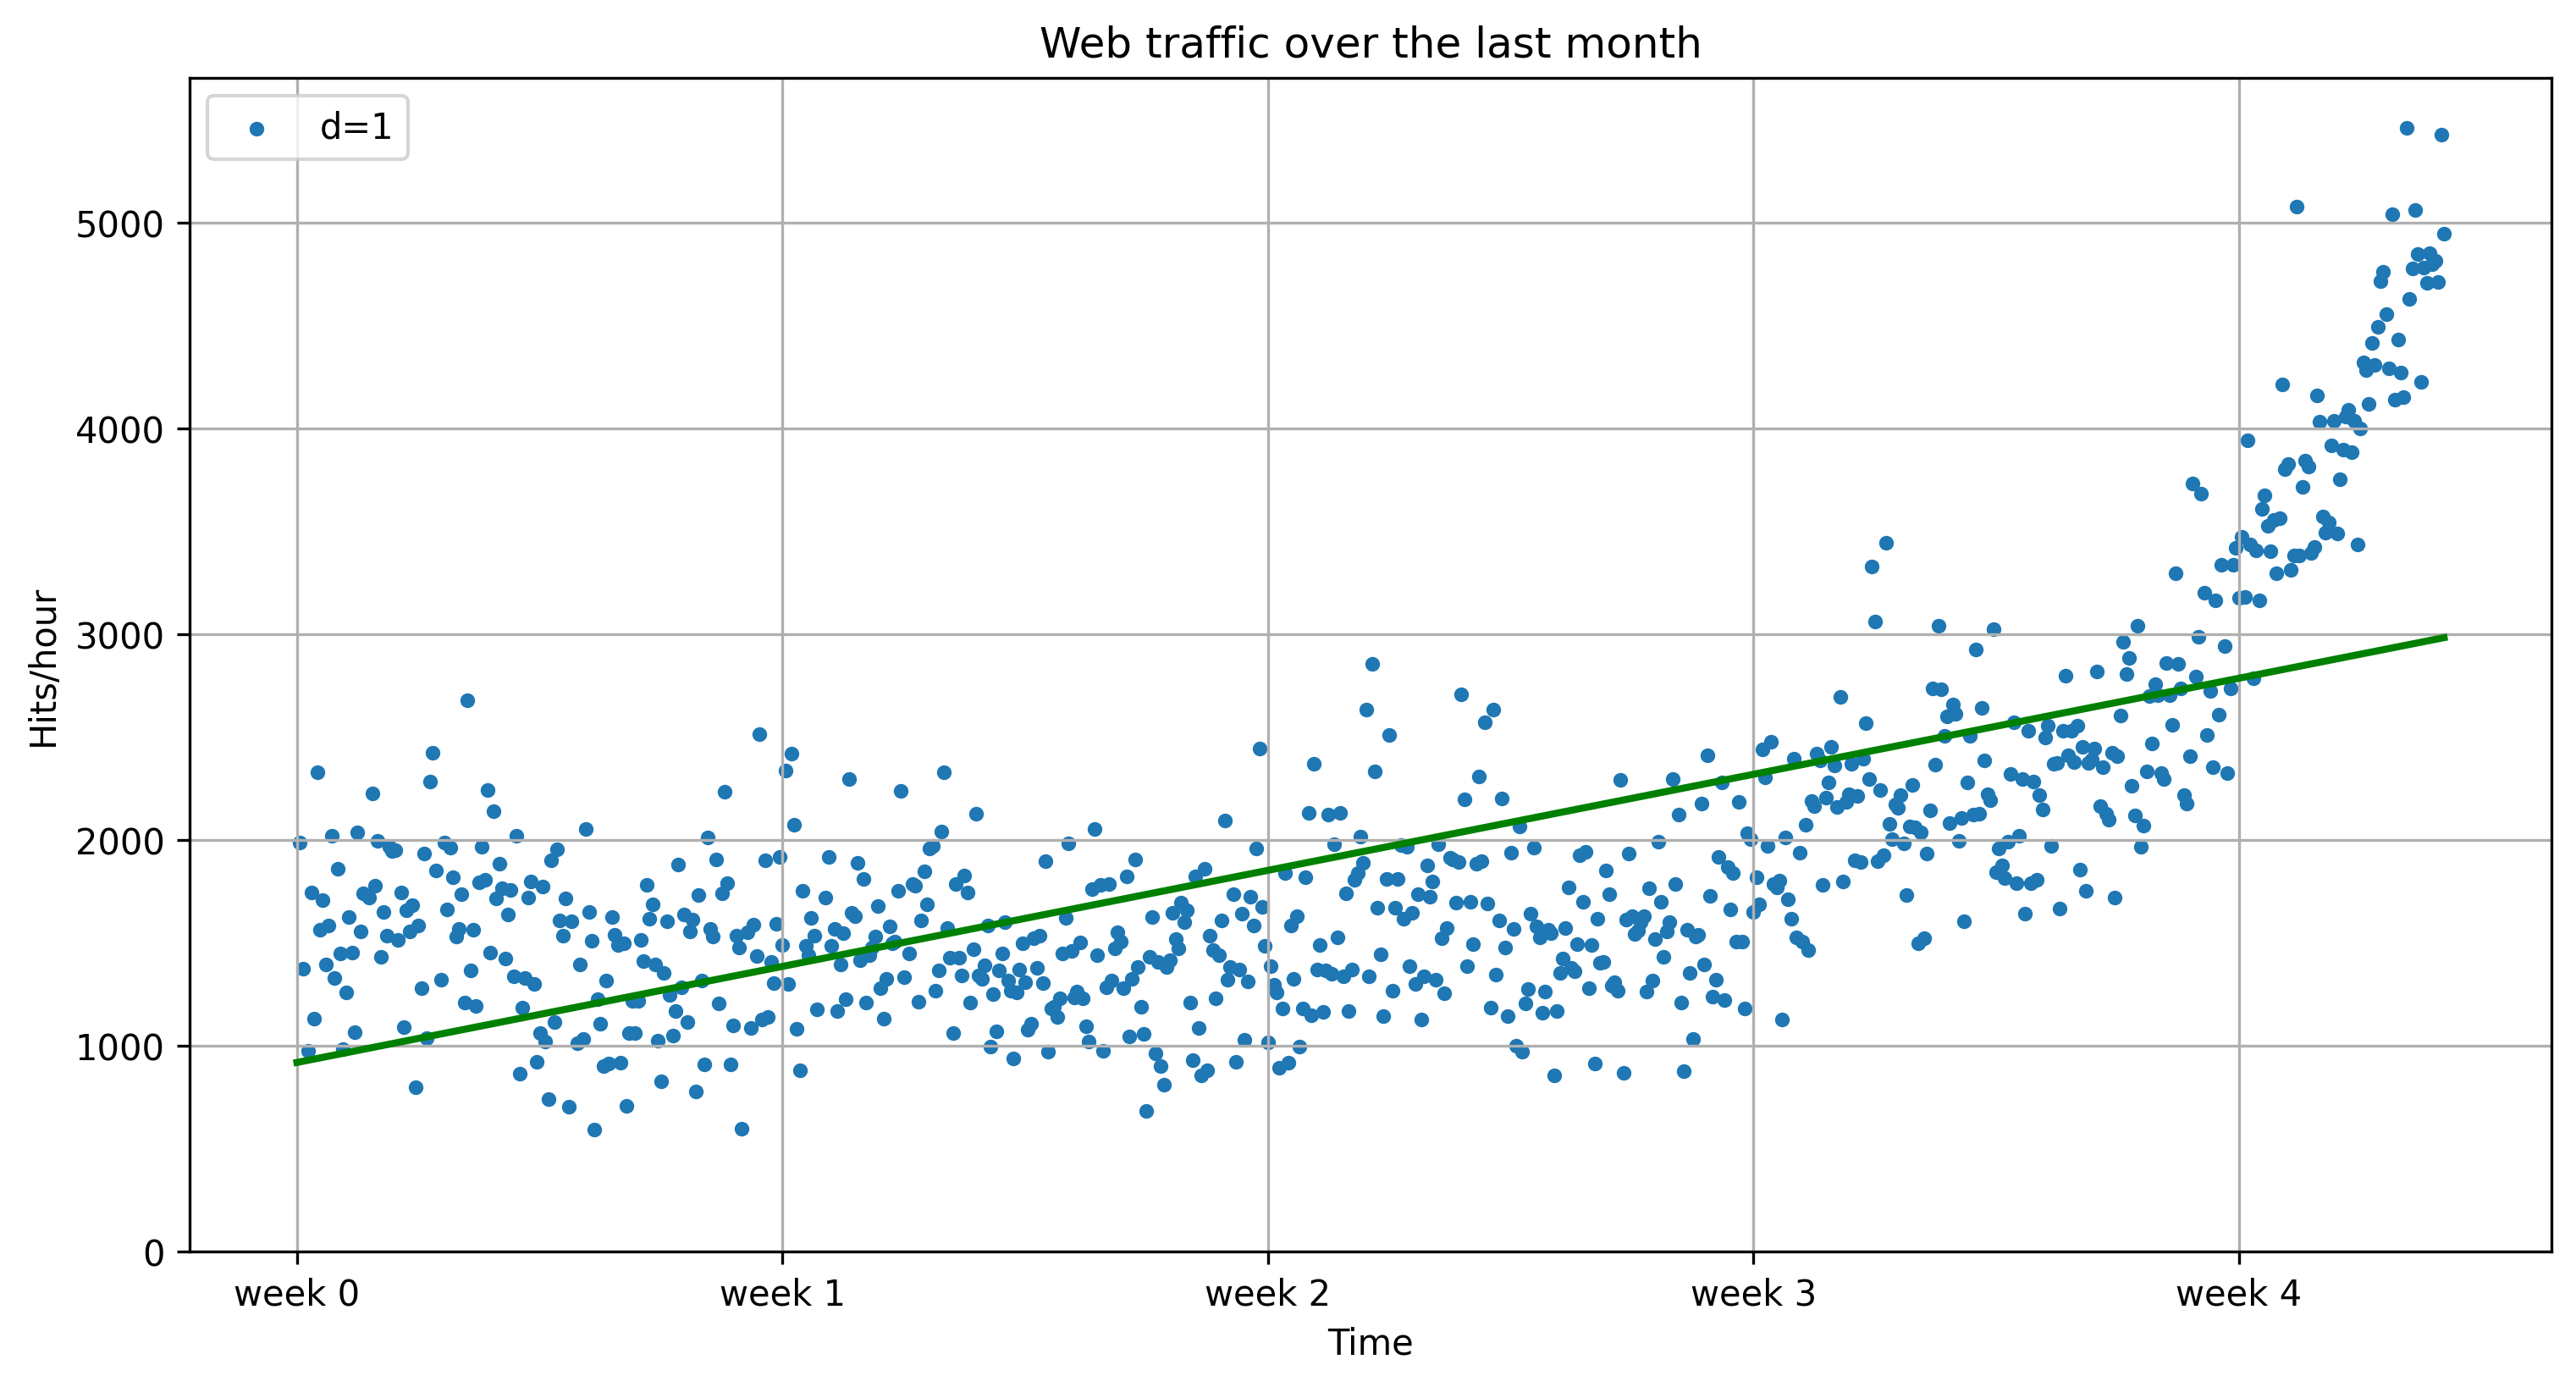

In [26]:
plot_web_traffic(x, y, [f1], fig_idx="02")

Clearly, our web traffic cannot be modeled with only one dimension. What about two?

In [47]:
f2p = np.polyfit(x, y, 2)

In [48]:
print(f2p)

[ 1.05605675e-02 -5.29774287e+00  1.98466917e+03]


In [49]:
f2 = np.poly1d(f2p)

In [50]:
print(error(f2, x, y))

181347660.764236


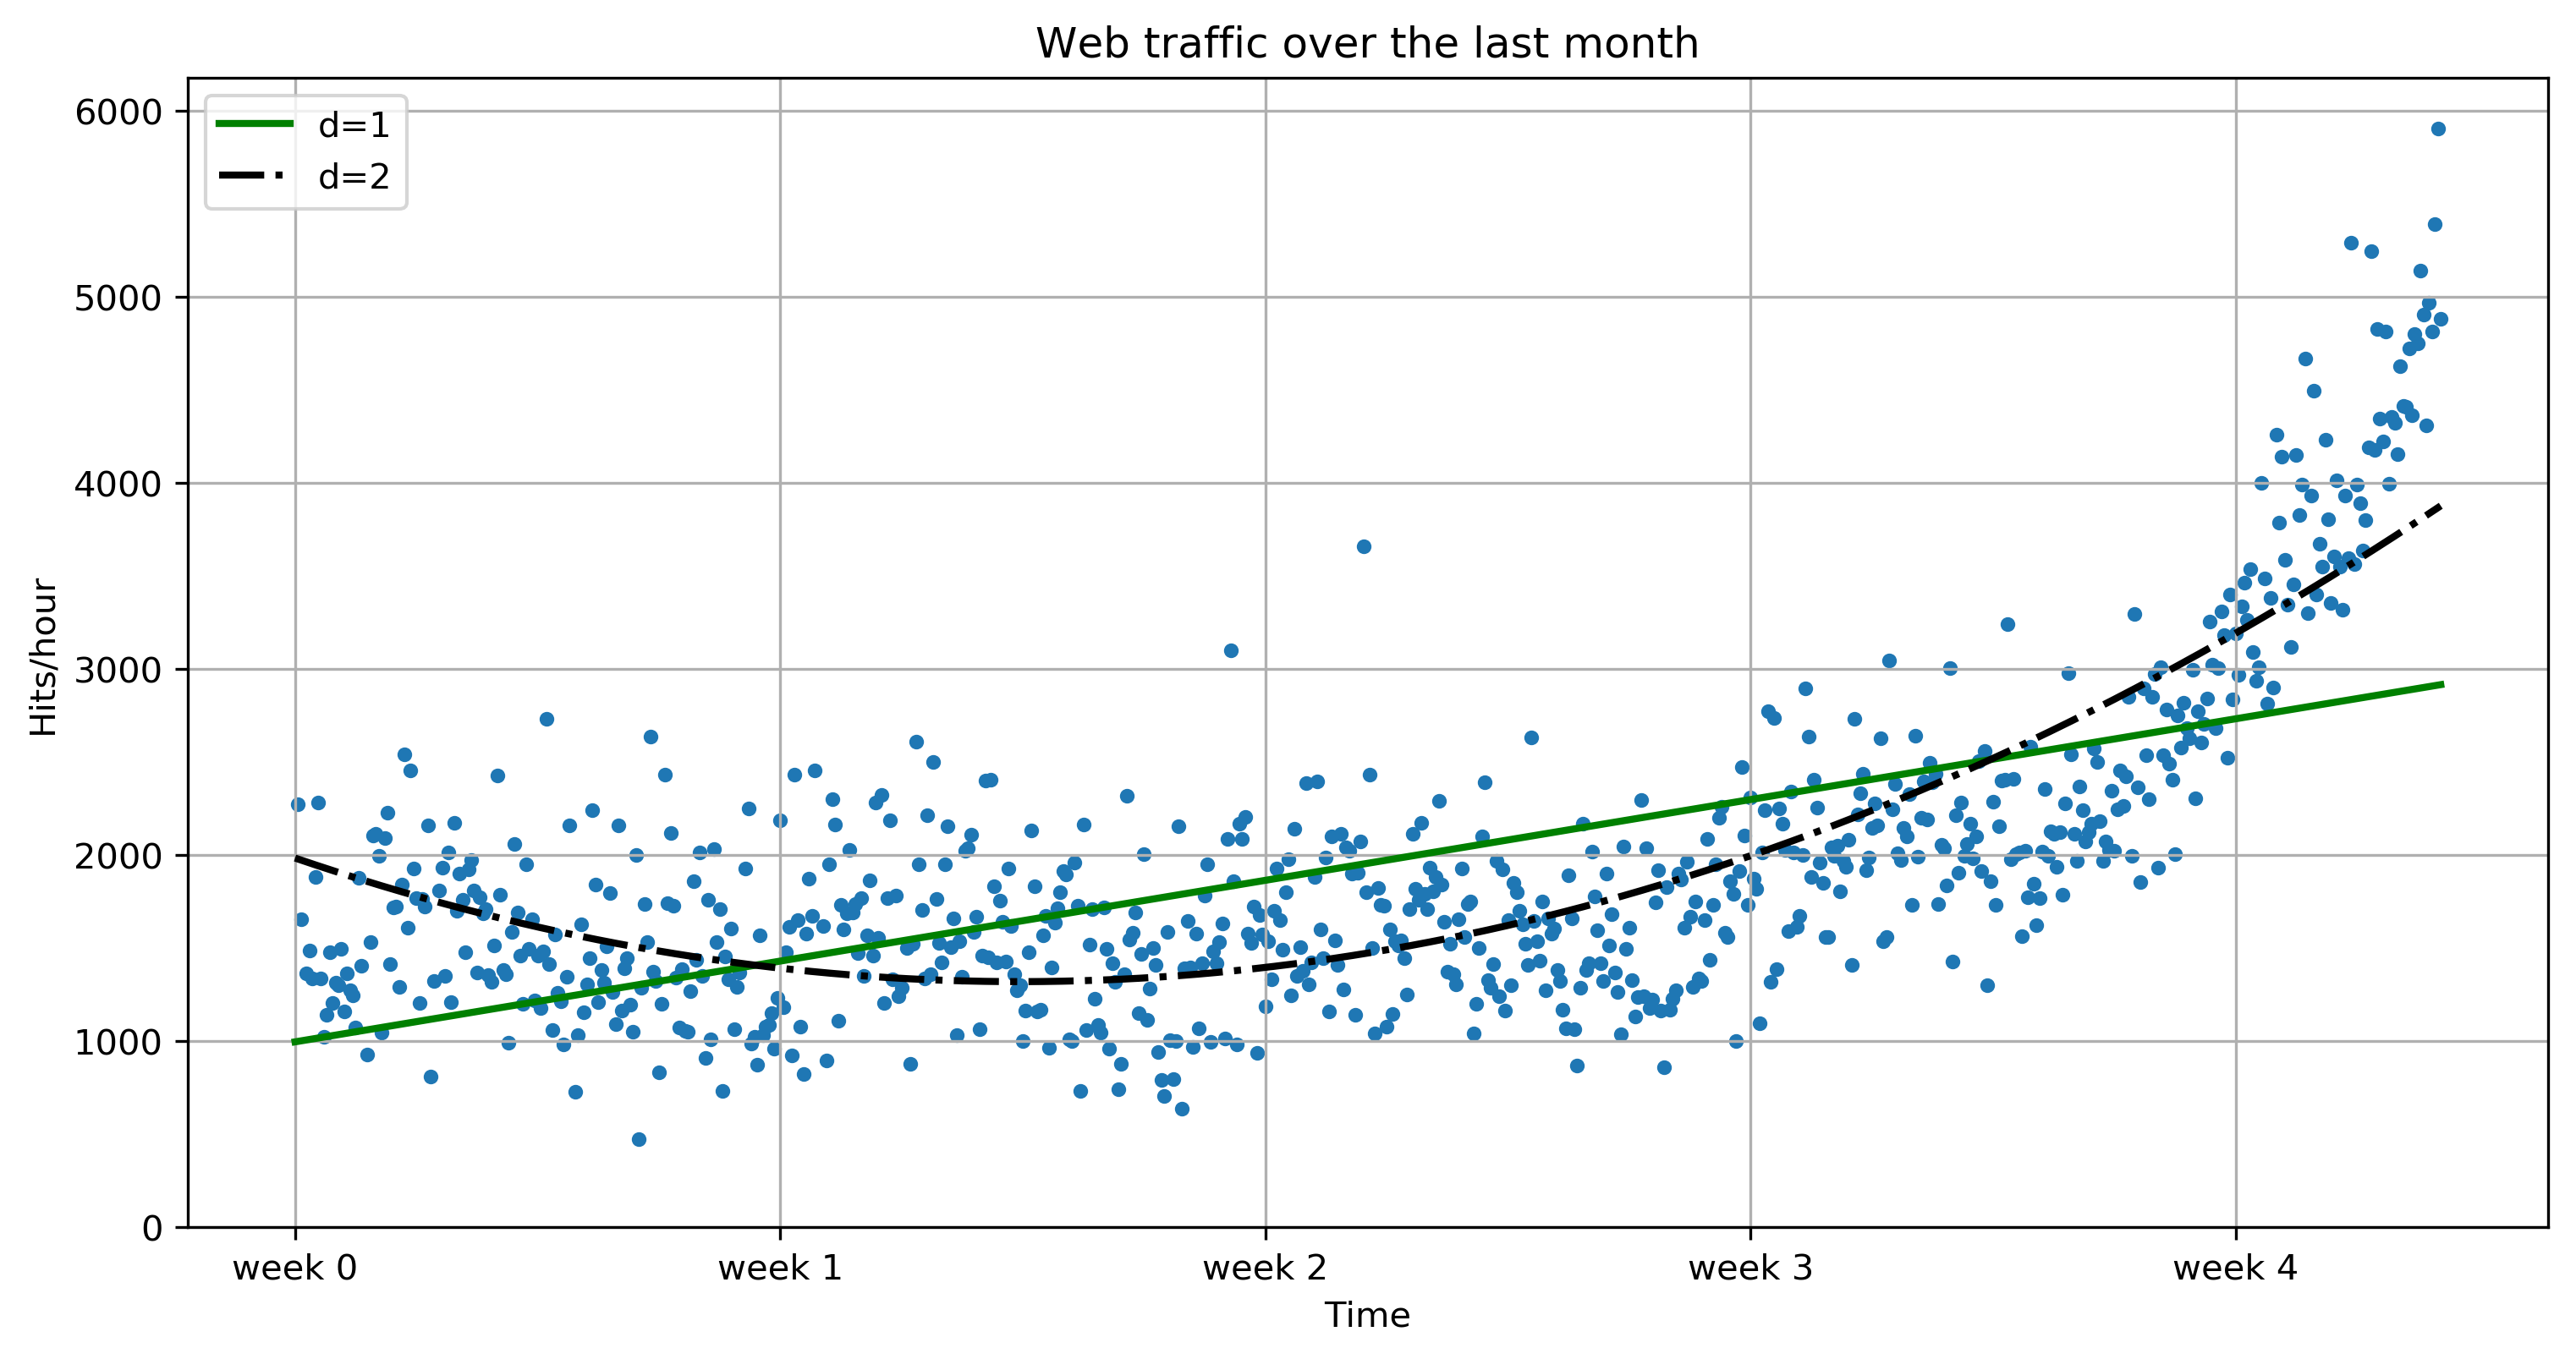

In [51]:
plot_web_traffic(x, y, [f1, f2], fig_idx="03")

In [52]:
f3 = np.poly1d(np.polyfit(x, y, 3))
f10 = np.poly1d(np.polyfit(x, y, 10))
f100 = np.poly1d(np.polyfit(x, y, 100))

c:\local\anaconda3-4.1.1-windows-x86_64\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
c:\local\anaconda3-4.1.1-windows-x86_64\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
c:\local\anaconda3-4.1.1-windows-x86_64\lib\site-packages\ipykernel\__main__.py:3: RankWarning: Polyfit may be poorly conditioned
  app.launch_new_instance()


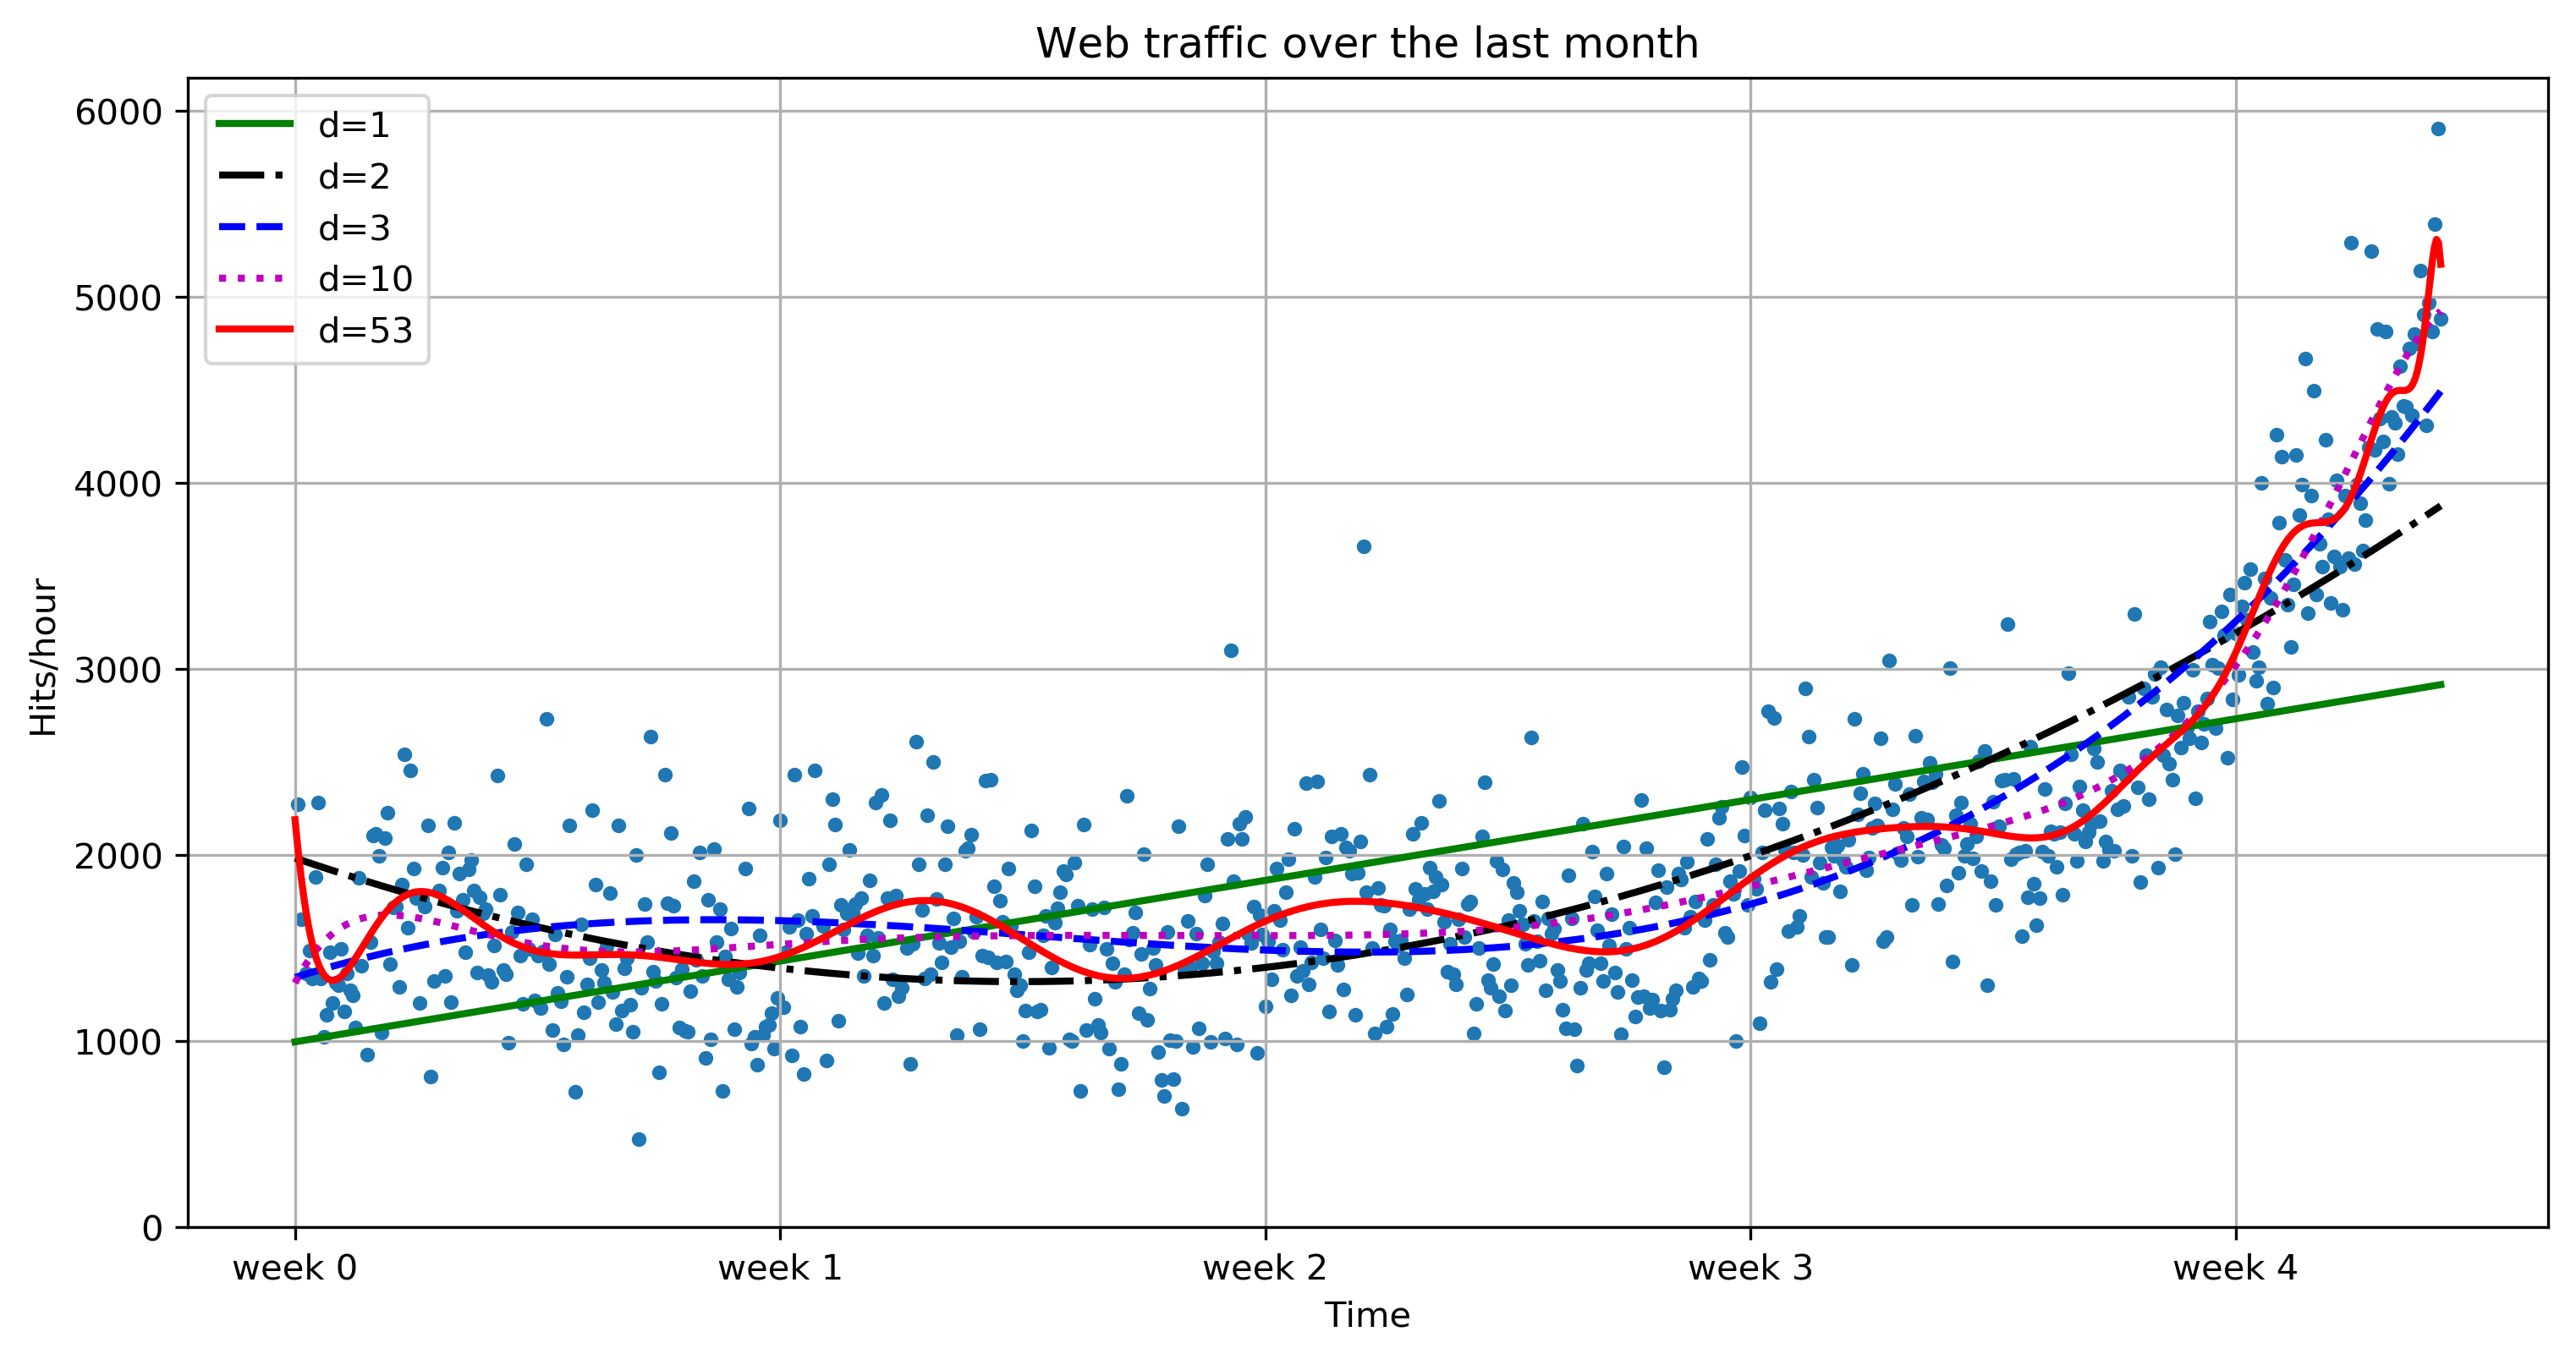

In [53]:
plot_web_traffic(x, y, [f1, f2, f3, f10, f100], fig_idx="04")

Ok, 100 was a bit overkill. 

In [54]:
print("Errors for the complete data set:")
for f in [f1, f2, f3, f10, f100]:
    print("\td=%i: %f" % (f.order, error(f, x, y)))

Errors for the complete data set:
	d=1: 319531507.008126
	d=2: 181347660.764236
	d=3: 140576460.879141
	d=10: 123426935.754277
	d=53: 110768265.091652


But maybe we just haven't found the right dimension, so let's play a bit.

**Note**: if you don't see an interactive slider below the following code block, you need to enable the interactive widgets by running

```jupyter nbextension enable --py widgetsnbextension```

in the console and restart `jupyter notebook`.

In [55]:
from ipywidgets import interactive
import ipywidgets as widgets

def play_with_dim(dim=1):
    f = np.poly1d(np.polyfit(x, y, dim))
    plot_web_traffic(x, y, [f])
    print("Error for d=%i: %f" % (f.order, error(f, x, y)))
    
interactive_plot = interactive(play_with_dim, dim=(1,100))
output = interactive_plot.children[-1]
output.layout.height = '500px'
interactive_plot

interactive(children=(IntSlider(value=1, description='dim', min=1), Output(layout=Layout(height='500px'))), _d…

## Stepping back to go forward...
It seems like there is some change between week 3 and 4. What if we treat the time before and after differently?

In [56]:
inflection = int(3.5*7*24) # calculate the inflection point in hours
xa = x[:inflection] # data before the inflection point
ya = y[:inflection]
xb = x[inflection:] # data after
yb = y[inflection:]

fa = np.poly1d(np.polyfit(xa, ya, 1))
fb = np.poly1d(np.polyfit(xb, yb, 1))

fa_error = error(fa, xa, ya)
fb_error = error(fb, xb, yb)
print("Error inflection=%f" % (fa_error + fb_error))

Error inflection=134390576.310656


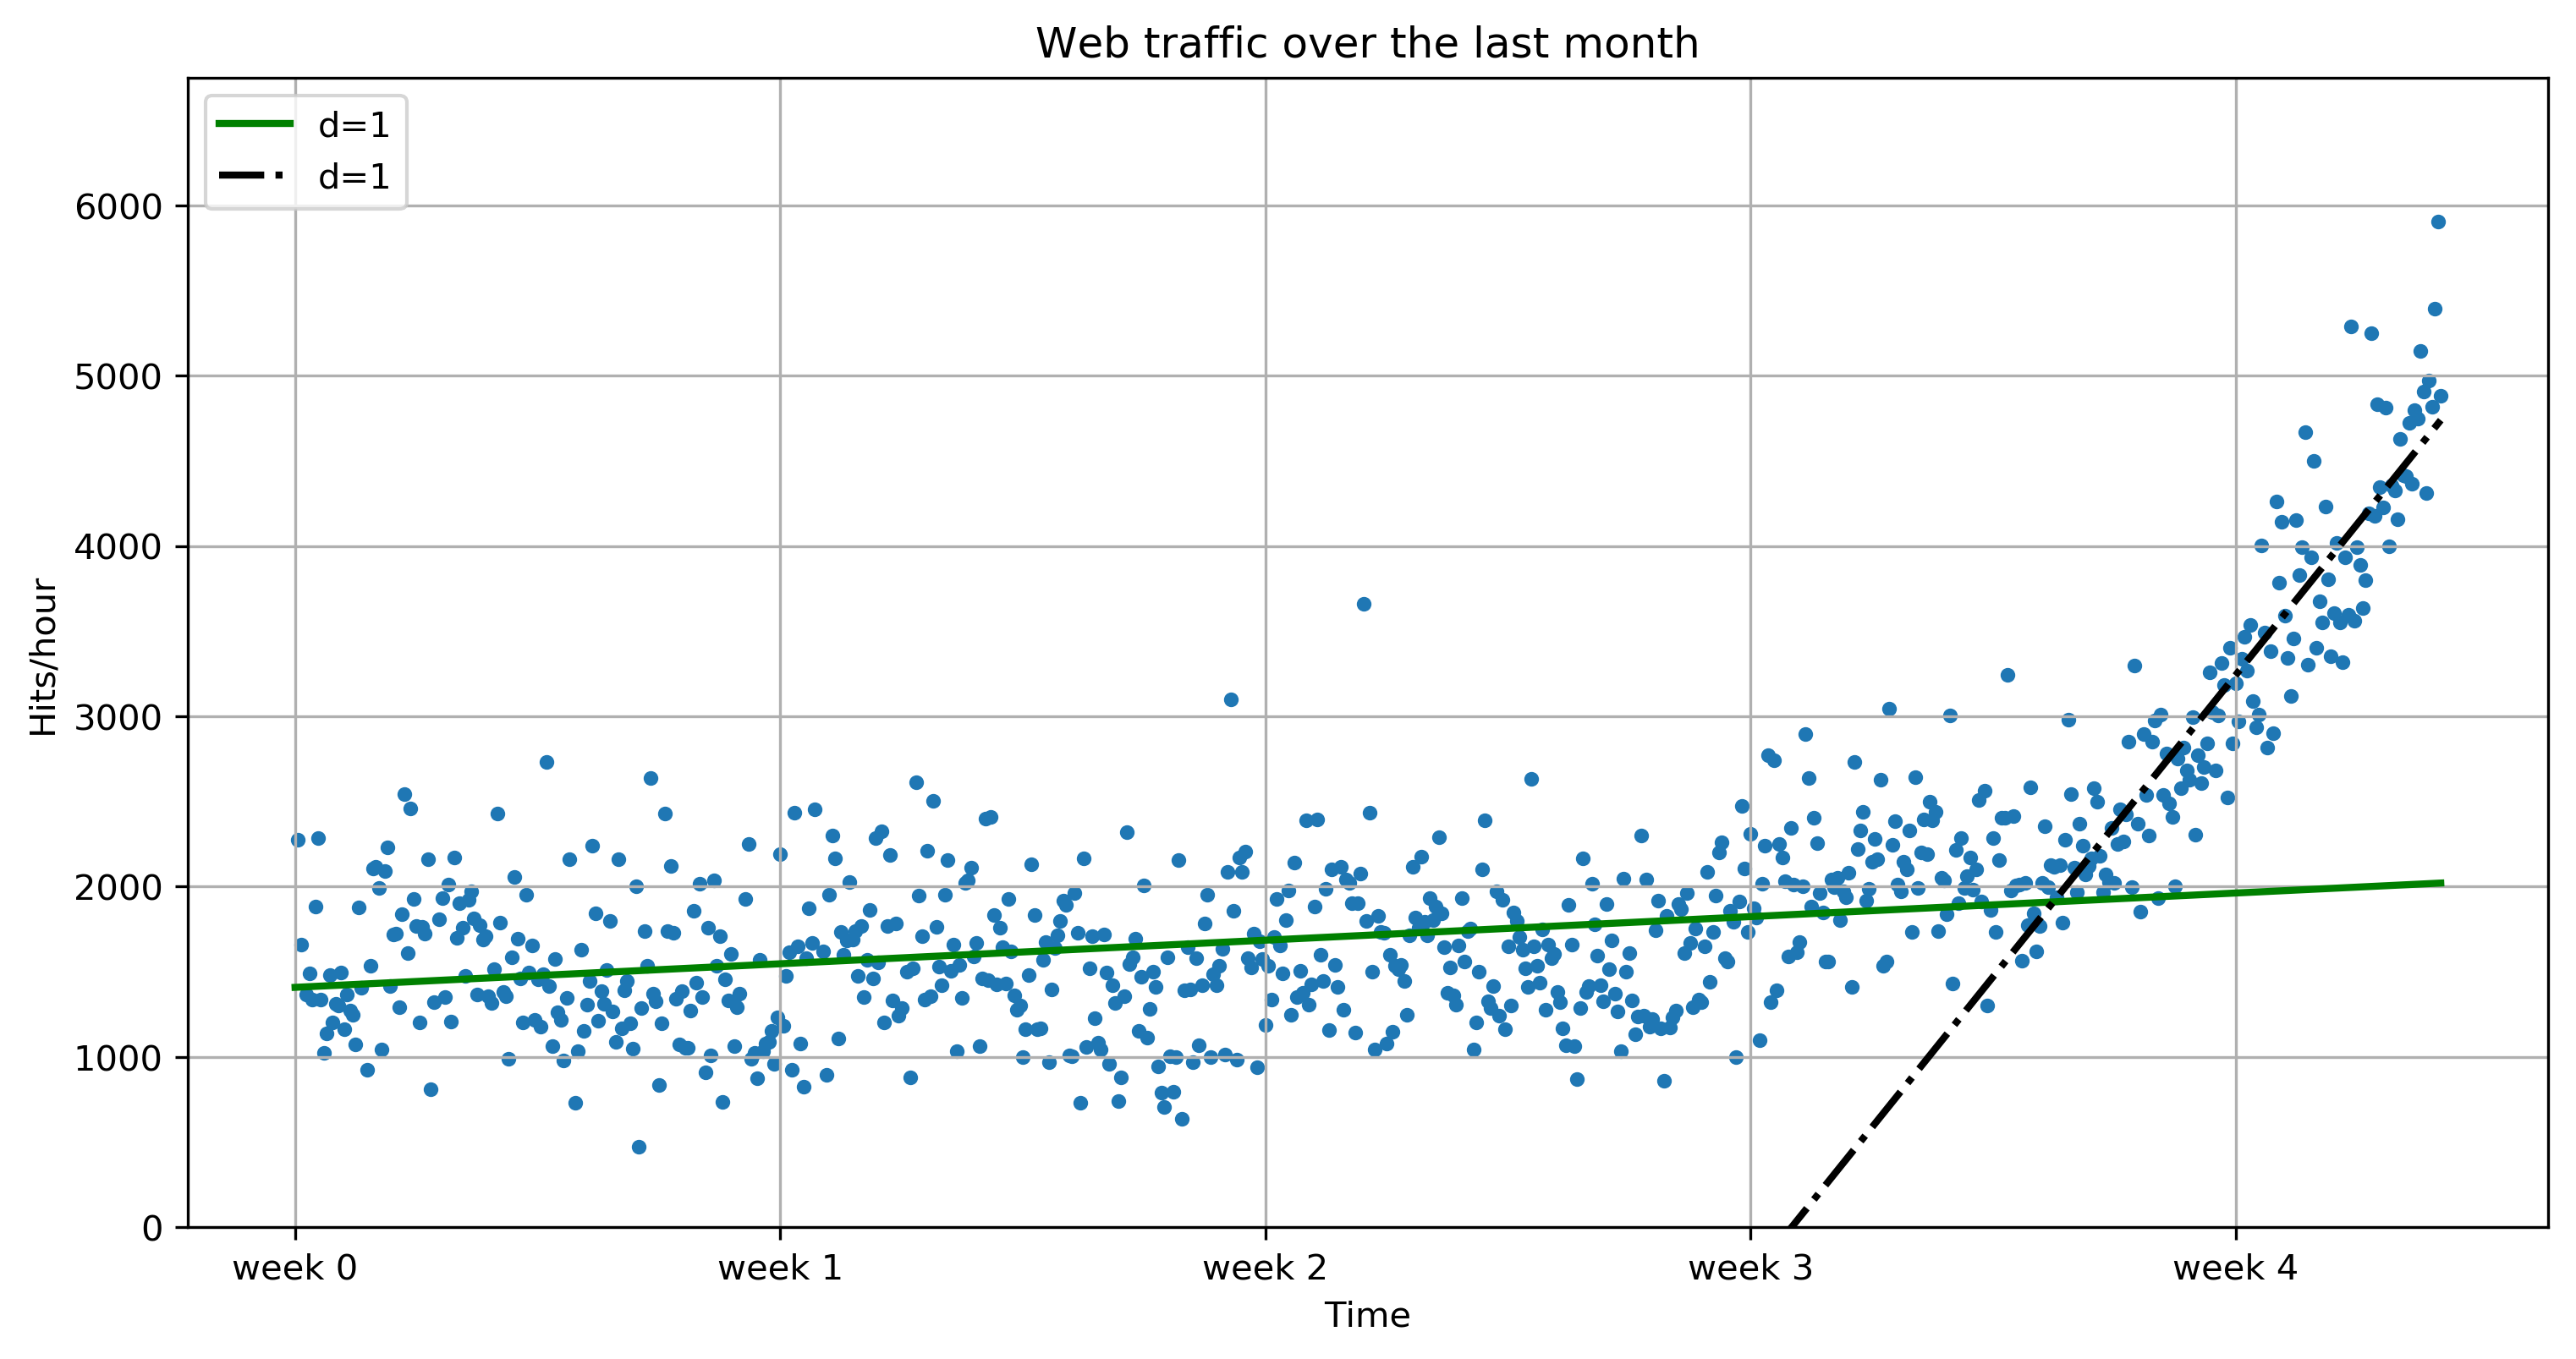

In [57]:
fa = np.poly1d(np.polyfit(xa, ya, 1))
fb = np.poly1d(np.polyfit(xb, yb, 1))

plot_web_traffic(x, y, [fa, fb], fig_idx="05")

How perform our higher-degree models with our "inflection" version?

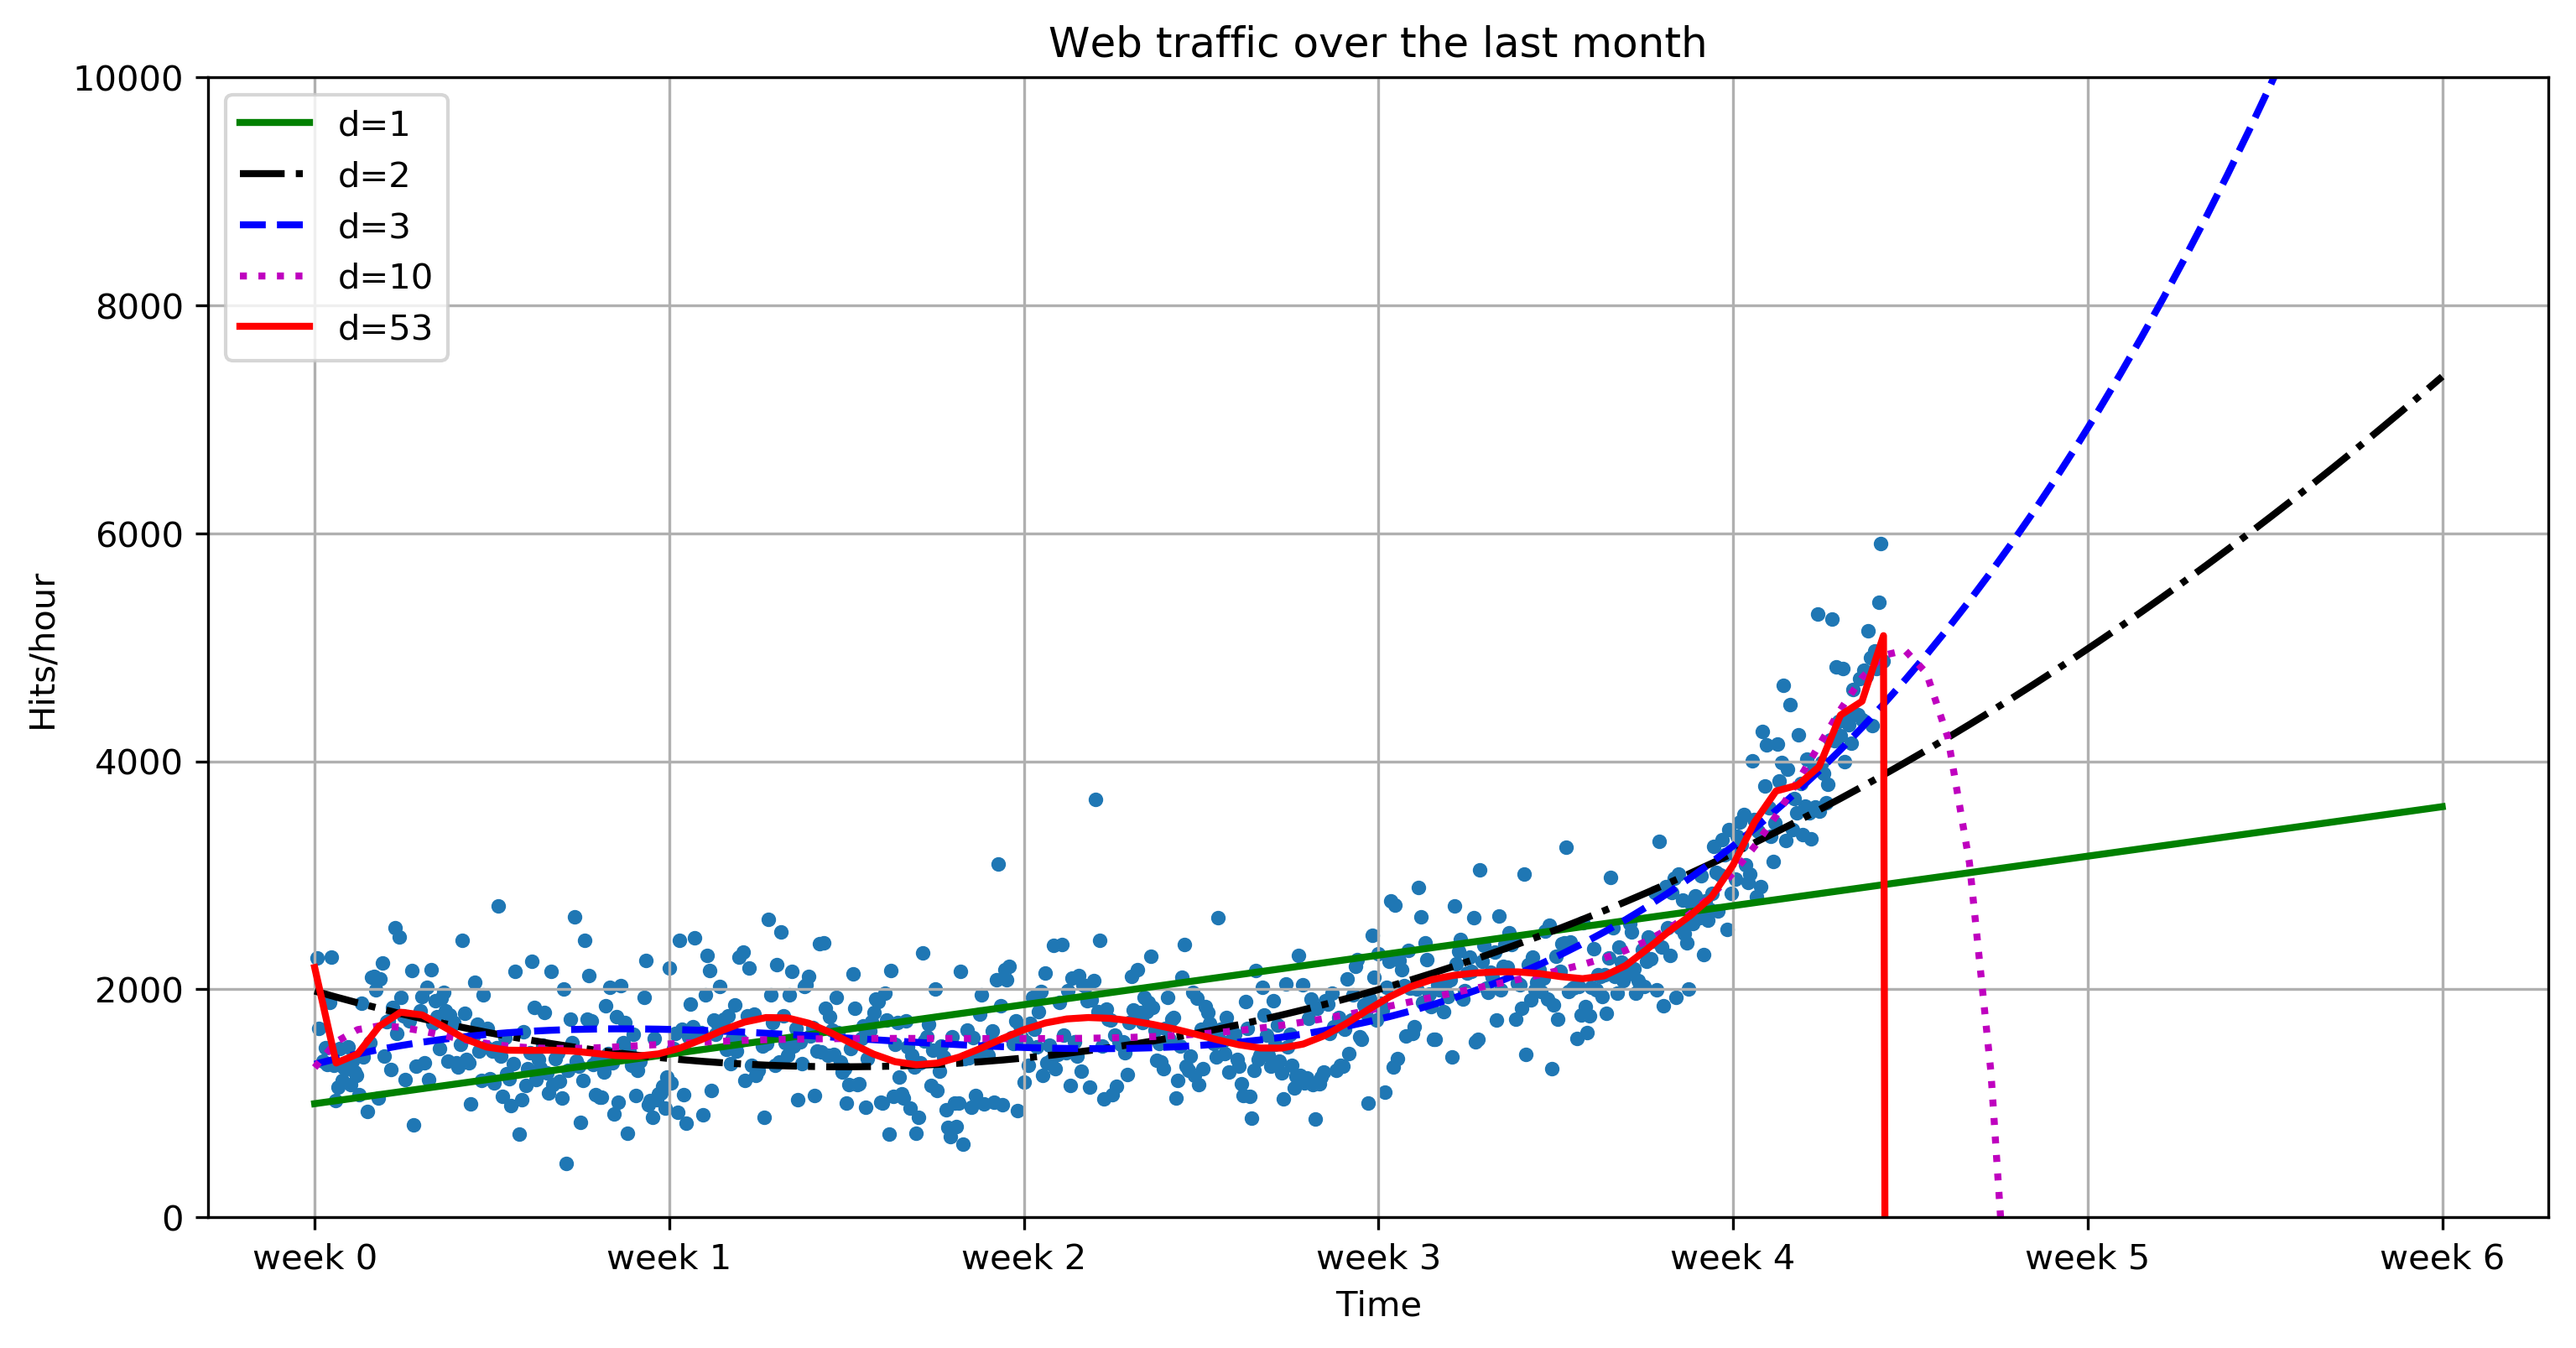

In [58]:
plot_web_traffic(x, y, [f1, f2, f3, f10, f100],
    mx=np.linspace(0, 6 * 7 * 24, 100),
    ymax=10000,
    fig_idx="06")

Ok, higher degree models don't give hope for a bright future. 
What if we had trained them onlz on the last week?

c:\local\anaconda3-4.1.1-windows-x86_64\lib\site-packages\ipykernel\__main__.py:4: RankWarning: Polyfit may be poorly conditioned
c:\local\anaconda3-4.1.1-windows-x86_64\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
c:\local\anaconda3-4.1.1-windows-x86_64\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
c:\local\anaconda3-4.1.1-windows-x86_64\lib\site-packages\ipykernel\__main__.py:5: RankWarning: Polyfit may be poorly conditioned


Errors for only the time after inflection point
	d=1: 22140590.598233
	d=2: 19764355.660080
	d=3: 19762196.404203
	d=10: 18942545.584858
	d=53: 18293843.639658


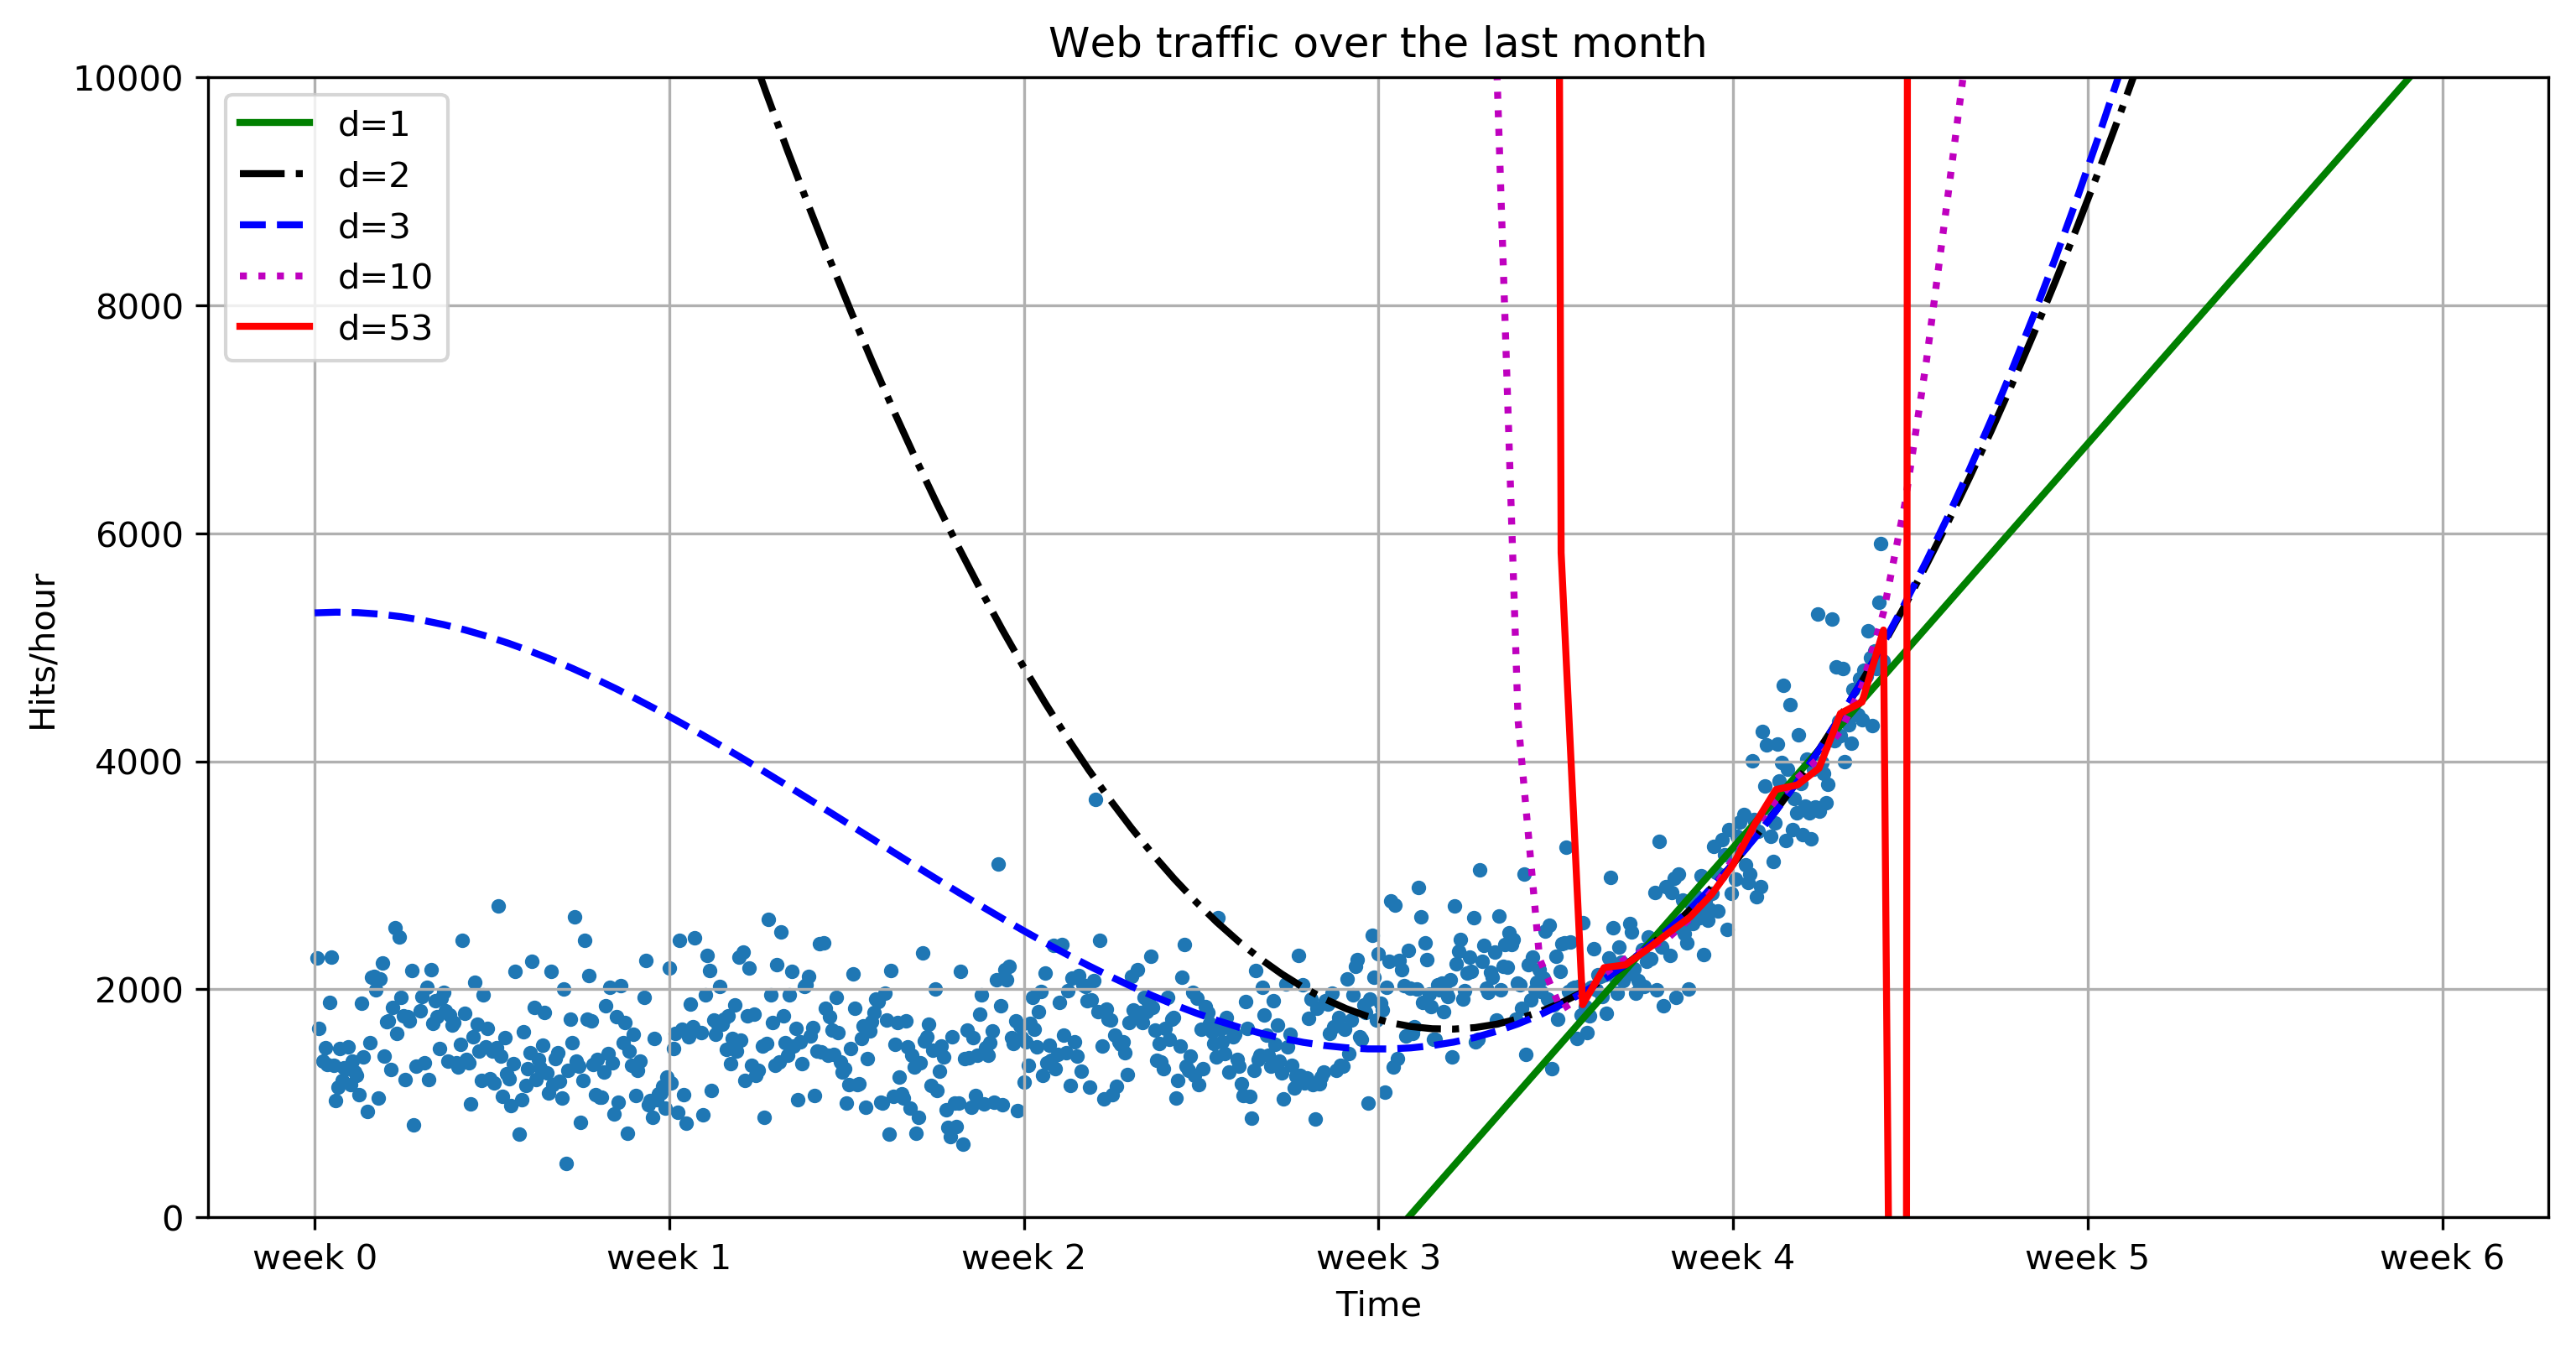

In [59]:
fb1 = np.poly1d(np.polyfit(xb, yb, 1))
fb2 = np.poly1d(np.polyfit(xb, yb, 2))
fb3 = np.poly1d(np.polyfit(xb, yb, 3))
fb10 = np.poly1d(np.polyfit(xb, yb, 10))
fb100 = np.poly1d(np.polyfit(xb, yb, 100))

print("Errors for only the time after inflection point")
for f in [fb1, fb2, fb3, fb10, fb100]:
    print("\td=%i: %f" % (f.order, error(f, xb, yb)))

plot_web_traffic(
    x, y, [fb1, fb2, fb3, fb10, fb100],    
    mx=np.linspace(0, 6 * 7 * 24, 100),
    ymax=10000,
    fig_idx="07")

## Splitting training and testing
Let's use 30% of the web traffic data after the inflection point as test data that we do not train on.

In [60]:
frac = 0.3
split_idx = int(frac * len(xb))
shuffled = np.random.permutation(list(range(len(xb))))
test = sorted(shuffled[:split_idx])
train = sorted(shuffled[split_idx:])
fbt1 = np.poly1d(np.polyfit(xb[train], yb[train], 1))
fbt2 = np.poly1d(np.polyfit(xb[train], yb[train], 2))
print("fbt2(x)= \n%s" % fbt2)
print("fbt2(x)-100,000= \n%s" % (fbt2-100000))
fbt3 = np.poly1d(np.polyfit(xb[train], yb[train], 3))
fbt10 = np.poly1d(np.polyfit(xb[train], yb[train], 10))
fbt100 = np.poly1d(np.polyfit(xb[train], yb[train], 100))

print("Test errors for only the time after inflection point")
for f in [fbt1, fbt2, fbt3, fbt10, fbt100]:
    print("Error d=%i: %f" % (f.order, error(f, xb[test], yb[test])))


fbt2(x)= 
         2
0.05404 x - 50.39 x + 1.262e+04
fbt2(x)-100,000= 
         2
0.05404 x - 50.39 x - 8.738e+04
Test errors for only the time after inflection point
Error d=1: 6492812.705336
Error d=2: 5008335.504620
Error d=3: 5006519.831510
Error d=10: 5440711.475354
Error d=53: 5369500.475302


c:\local\anaconda3-4.1.1-windows-x86_64\lib\site-packages\ipykernel\__main__.py:11: RankWarning: Polyfit may be poorly conditioned
c:\local\anaconda3-4.1.1-windows-x86_64\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
c:\local\anaconda3-4.1.1-windows-x86_64\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
c:\local\anaconda3-4.1.1-windows-x86_64\lib\site-packages\ipykernel\__main__.py:12: RankWarning: Polyfit may be poorly conditioned


Errors for only the time after inflection point
	d=1: 22140590.598233
	d=2: 19764355.660080
	d=3: 19762196.404203
	d=10: 18942545.584858
	d=53: 18293843.639658


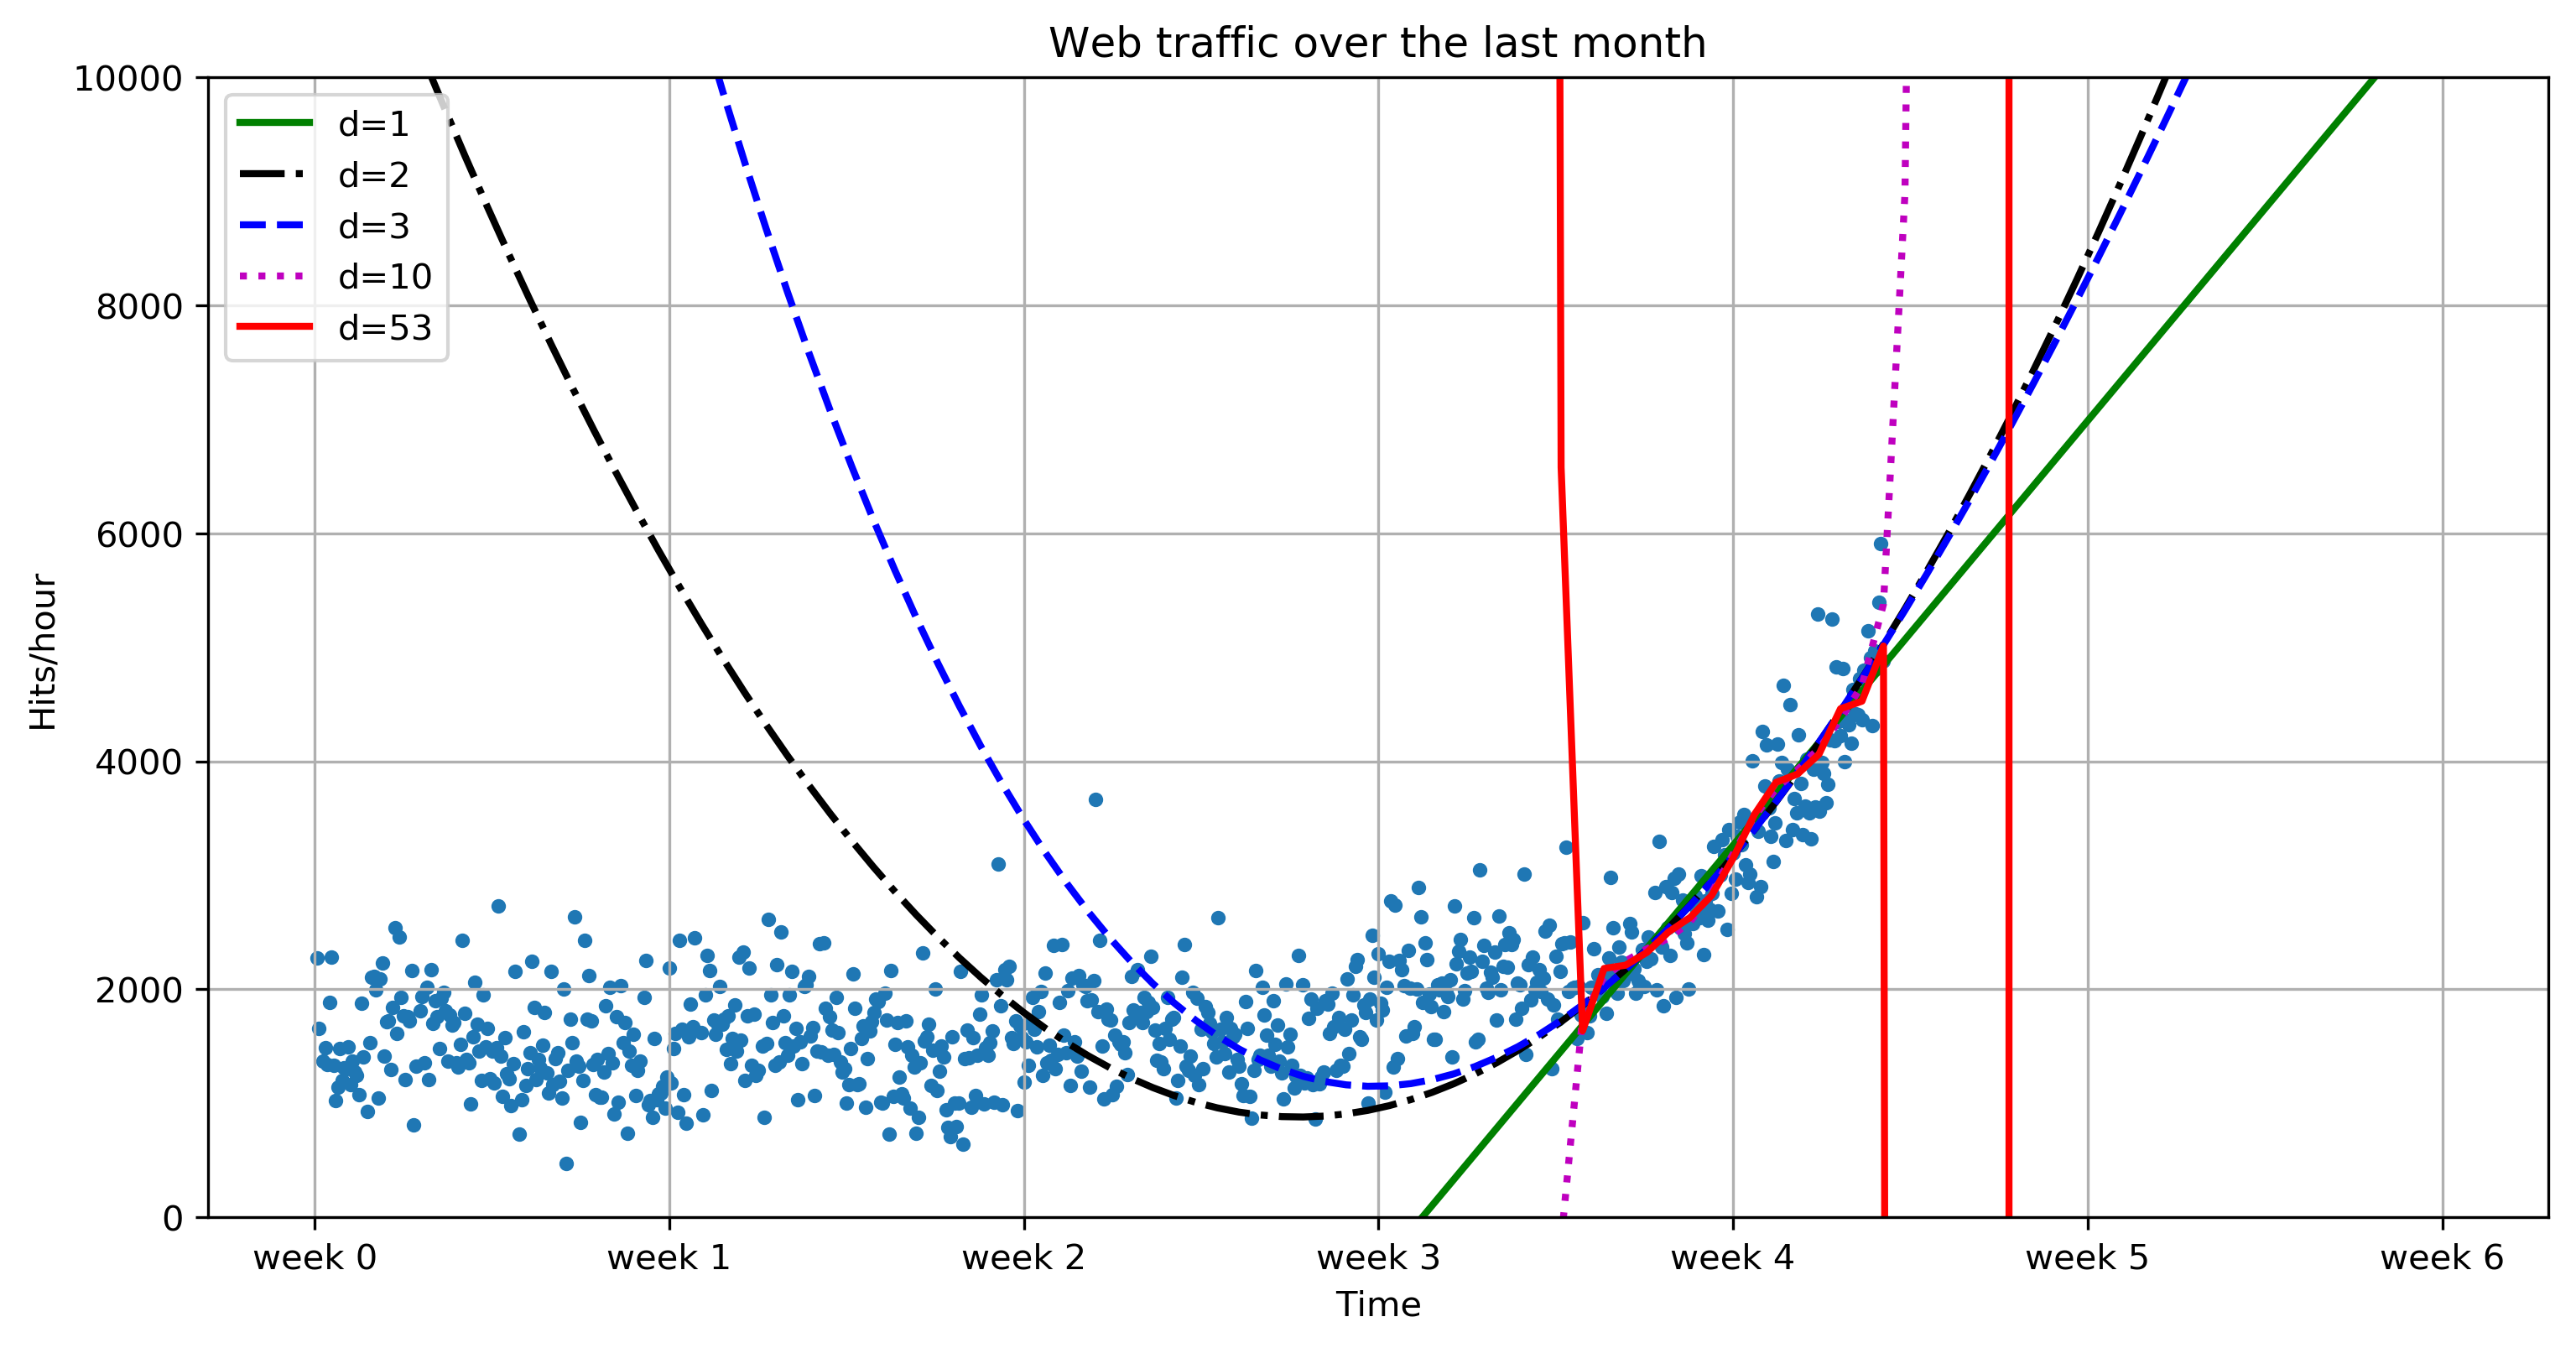

In [61]:
print("Errors for only the time after inflection point")
for f in [fb1, fb2, fb3, fb10, fb100]:
    print("\td=%i: %f" % (f.order, error(f, xb, yb)))

plot_web_traffic(
    x, y, [fbt1, fbt2, fbt3, fbt10, fbt100],    
    mx=np.linspace(0, 6 * 7 * 24, 100),
    ymax=10000,
    fig_idx="08")

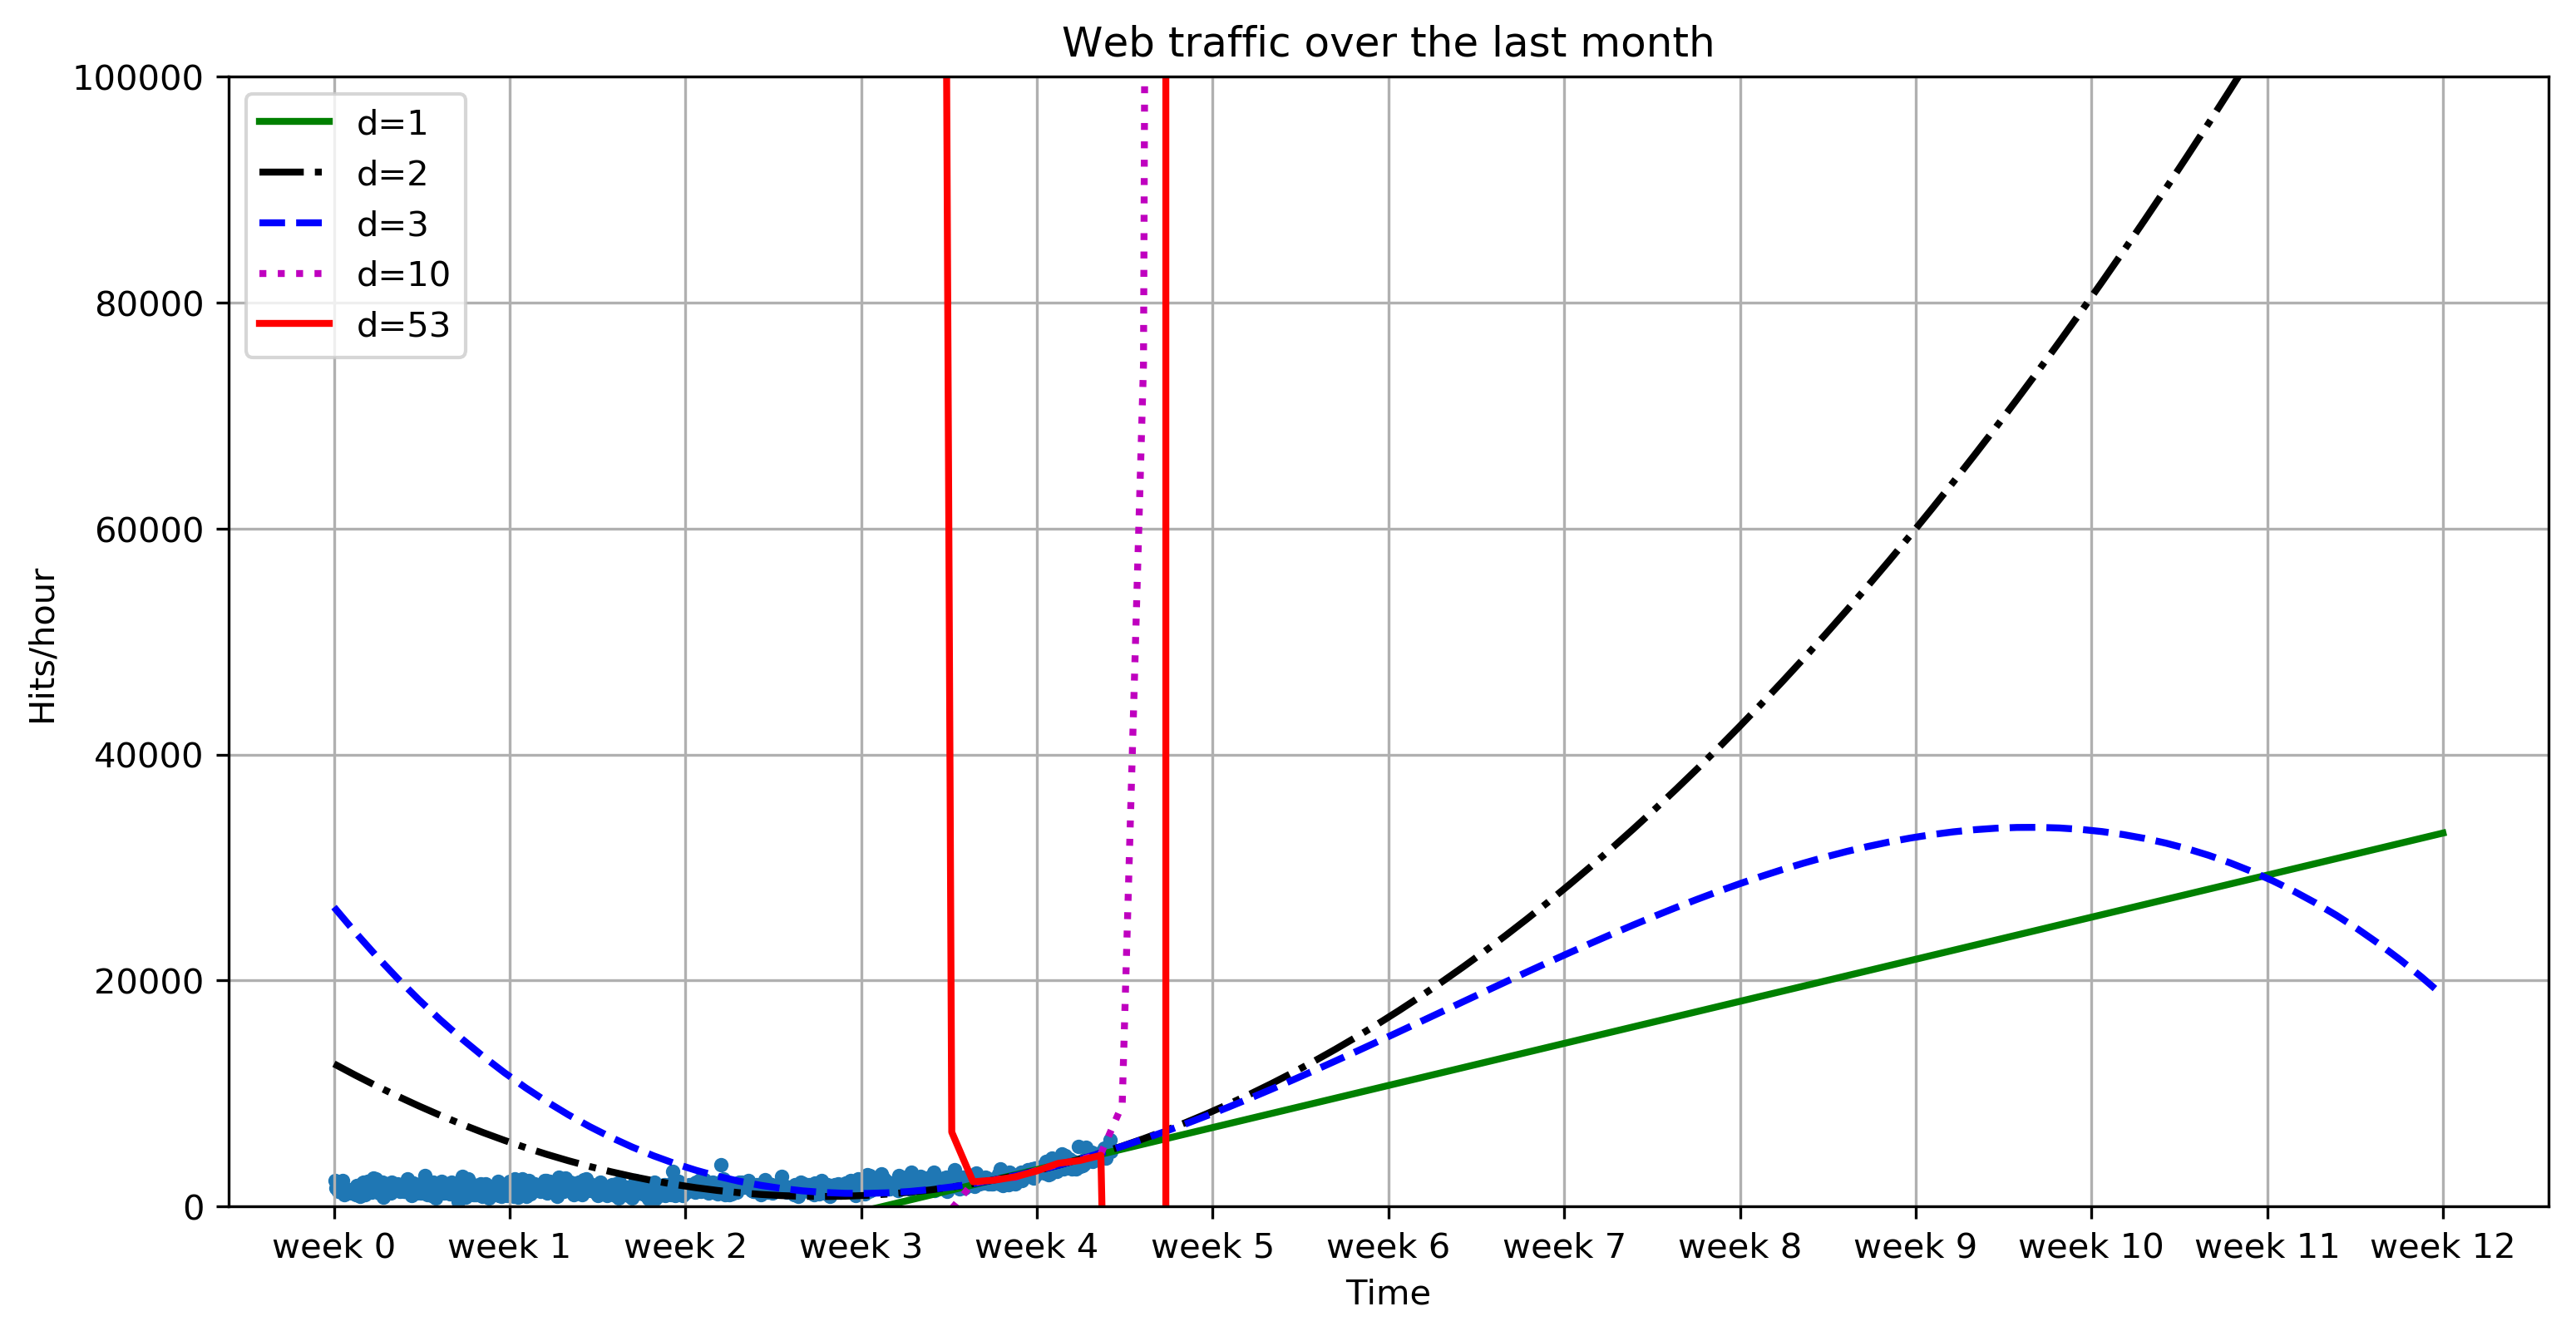

In [62]:
plot_web_traffic(
    x, y, [fbt1, fbt2, fbt3, fbt10, fbt100],    
    mx=np.linspace(0, 12 * 7 * 24, 100),
    ymax=100000,
    fig_idx="09")

## So, when will we hit 100,000 hits per hour?

In [63]:
fbt2 = np.poly1d(np.polyfit(xb[train], yb[train], 2))
print("fbt2(x)= \n%s" % fbt2)
print("fbt2(x)-100,000= \n%s" % (fbt2-100000))

from scipy.optimize import fsolve
reached_max = fsolve(fbt2-100000, x0=800)/(7*24)
print("100,000 hits/hour expected at week %f" % reached_max[0])

fbt2(x)= 
         2
0.05404 x - 50.39 x + 1.262e+04
fbt2(x)-100,000= 
         2
0.05404 x - 50.39 x - 8.738e+04
100,000 hits/hour expected at week 10.836350
